# NTRES 4560 Stream Ecology: Leaf Packs Project Class Data Analysis

In [123]:
import pandas as pd
import numpy as np

import duckdb

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc
#import researchpy as rp
import scipy.stats as stats

## Mass Loss

### Data Import and Cleaning

In [2]:
mass_df = pd.read_csv("Class_massloss.csv")
mass_df

,Group,Species,Replicate,Treatment,Week,Initial_Mass,Dried_Mass,Proportion
0,1,Red Maple,1,C,0,3.00,2.80,0.933333
1,1,Red Maple,2,C,0,3.00,2.70,0.900000
2,1,Red Maple,3,C,0,2.90,2.70,0.931034
3,1,Red Maple,1,C,2,3.00,1.34,0.446667
4,1,Red Maple,2,C,2,3.00,1.10,0.366667
...,...,...,...,...,...,...,...,...
450,12,Red Oak,2,L,0,3.02,2.92,0.966887
451,12,Red Oak,3,L,0,2.97,3.04,1.023569
452,12,Alder,1,L,0,3.00,2.42,0.806667
453,12,Alder,2,L,0,2.95,2.41,0.816949


In [3]:
mass_w0_df = mass_df.loc[mass_df['Week']==0].copy()
corr_factor = mass_w0_df.loc[mass_w0_df['Treatment']!="L"].copy()
corr_factor['Corr_Factor']=mass_w0_df['Initial_Mass']/mass_w0_df['Dried_Mass']

corr_factor = duckdb.sql("""SELECT "Group", Species, Treatment, AVG(Corr_Factor) AS Corr_Factor
                                FROM corr_factor
                                GROUP BY "Group", Species, Treatment""").df()
corr_factor

,Group,Species,Treatment,Corr_Factor
0,1,Red Maple,C,1.085538
1,1,Wild Grape,C,1.188580
2,2,American Sycamore,C,1.051722
3,2,Black Walnut,C,1.142463
4,3,Red Maple,C,1.088479
5,3,Wild Grape,C,6.501667
6,4,Black Walnut,C,1.117357
7,4,American Sycamore,C,1.094321
8,5,Eastern Cottonwood,C,1.133670
9,5,American Beech,C,1.203257


In [4]:
mass_df = mass_df.merge(corr_factor, how='left', on=['Group','Species','Treatment'])
mass_df['Corr_Factor'] = mass_df['Corr_Factor'].fillna(1)

In [5]:
mass_df['Corr_Proportion'] = mass_df['Proportion']*mass_df['Corr_Factor']

def replace_0(o):
    if o == 0:
        return 0.0000000001
    return o
mass_df['Corr_Proportion'] = mass_df['Corr_Proportion'].apply(replace_0)
mass_df['ln_Corr_Proportion'] = np.log(mass_df['Corr_Proportion'])

mass_df

,Group,Species,Replicate,Treatment,Week,Initial_Mass,Dried_Mass,Proportion,Corr_Factor,Corr_Proportion,ln_Corr_Proportion
0,1,Red Maple,1,C,0,3.00,2.80,0.933333,1.085538,1.013169,0.013083
1,1,Red Maple,2,C,0,3.00,2.70,0.900000,1.085538,0.976984,-0.023285
2,1,Red Maple,3,C,0,2.90,2.70,0.931034,1.085538,1.010673,0.010617
3,1,Red Maple,1,C,2,3.00,1.34,0.446667,1.085538,0.484874,-0.723867
4,1,Red Maple,2,C,2,3.00,1.10,0.366667,1.085538,0.398031,-0.921226
...,...,...,...,...,...,...,...,...,...,...,...
450,12,Red Oak,2,L,0,3.02,2.92,0.966887,1.000000,0.966887,-0.033673
451,12,Red Oak,3,L,0,2.97,3.04,1.023569,1.000000,1.023569,0.023296
452,12,Alder,1,L,0,3.00,2.42,0.806667,1.000000,0.806667,-0.214845
453,12,Alder,2,L,0,2.95,2.41,0.816949,1.000000,0.816949,-0.202178


In [6]:
mass_leachmod_df = mass_df.copy()
mass_leachmod_df['Week'] = mass_leachmod_df['Week'].astype(float)
mass_leachmod_df['Week'].loc[mass_leachmod_df['Treatment']=='L'] = 2/7
mass_leachmod_df['Week'].unique()

/var/folders/6x/szq2cpyn3nlc0q6rcs6pxnp00000gn/T/ipykernel_39281/3716615524.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mass_leachmod_df['Week'].loc[mass_leachmod_df['Treatment']=='L'] = 2/7


array([0.        , 2.        , 4.        , 6.        , 0.28571429])

In [7]:
mass_add0_df = mass_df.loc[(mass_df['Treatment']=='F') | (mass_df['Treatment']=='L')].copy()
mass_add0_df = duckdb.sql("""SELECT Species, Treatment
                                FROM mass_add0_df
                                GROUP BY Species, Treatment""").df()
mass_add0_df['Week']=0
mass_add0_df['Replicate'],mass_add0_df['Initial_Mass'],mass_add0_df['Dried_Mass']=np.nan,np.nan,np.nan
mass_add0_df['Proportion'], mass_add0_df['Corr_Factor'], mass_add0_df['Corr_Proportion'] = 1.000000,1.000000,1.000000
mass_add0_df['ln_Corr_Proportion'] = np.log(mass_add0_df['Corr_Proportion'])

mass_mod_df = pd.concat([mass_leachmod_df, mass_add0_df])

In [8]:
K_df = pd.read_csv("Class_K.csv")
K_df.head()

,Treatment,Group,Species,K
0,C,1,Red Maple,0.0171
1,F,1,Red Maple,0.0133
2,C,1,Wild Grape,0.1358
3,F,1,Wild Grape,0.0354
4,C,2,American Sycamore,-0.0019


In [9]:
K_df['Species'].unique()

array(['Red Maple', 'Wild Grape', 'American Sycamore', 'Black Walnut',
       'American Beech', 'Eastern Cottonwood', 'Red Oak', 'Alder'],
      dtype=object)

In [66]:
mass_df["Species"].unique()

array(['Red Maple', 'Wild Grape', 'American Sycamore', 'Black Walnut',
       'Red Maple ', 'Eastern Cottonwood', 'American Beech', 'Red Oak',
       'Alder', 'Red Oak ', 'Eastern Cottonwood ', 'American Beech '],
      dtype=object)

### Recalculating Breakdown Rate

In [68]:
Group_l, Treatment_l, Species_l, K_l = [], [], [], []

for group in mass_df['Group'].unique():
    group_data = mass_df.loc[mass_df['Group']==group].copy()
    for treat in ['C', 'F']:
        group_treat_data = group_data.loc[group_data['Treatment']==treat].copy()
        for sp in group_treat_data["Species"].str.strip().unique():
            data = group_treat_data.loc[group_treat_data['Species'].str.strip()==sp].copy()
            data['Days'] = data['Week']*7
            X = data['Days']
            Y = data['ln_Corr_Proportion']
            model = sm.OLS(Y,X)
            results = model.fit()
            K_l.append(-results.params[0])
            Group_l.append(group)
            Treatment_l.append(treat)
            Species_l.append(sp)

new_K_df = pd.DataFrame({"Group": Group_l,
                         "Treatment": Treatment_l,
                         "Species": Species_l,
                         "K": K_l})
new_K_df

,Group,Treatment,Species,K
0,1,C,Red Maple,0.027493
1,1,C,Wild Grape,0.324193
2,1,F,Red Maple,0.032005
3,1,F,Wild Grape,0.048064
4,2,C,American Sycamore,0.005087
5,2,C,Black Walnut,0.135468
6,2,F,American Sycamore,0.009251
7,2,F,Black Walnut,0.011129
8,3,C,Red Maple,0.018731
9,3,C,Wild Grape,0.303009


### Visualisation

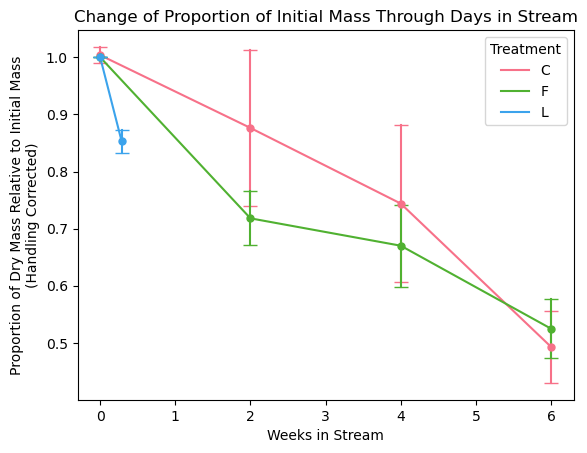

In [11]:
ax = sns.lineplot(data=mass_mod_df, 
                  x='Week', y='Corr_Proportion',
                  hue='Treatment', palette='husl',
                  err_style="bars", errorbar=("se", 2), err_kws=dict(fmt='o', markersize=5, capsize=5))

ax.set(title='Change of Proportion of Initial Mass Through Days in Stream',
       xlabel='Weeks in Stream', ylabel='Proportion of Dry Mass Relative to Initial Mass\n(Handling Corrected)')
plt.show;

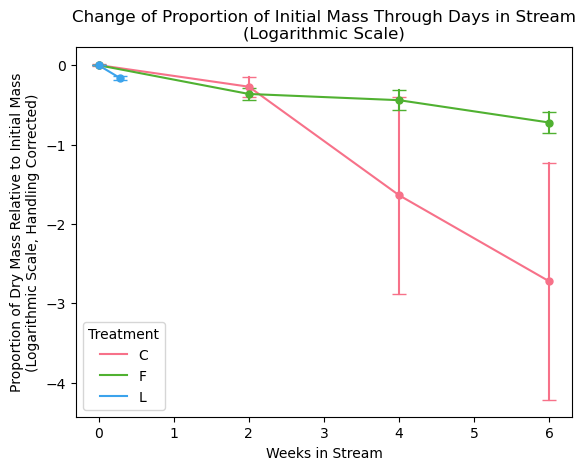

In [12]:
ax = sns.lineplot(data=mass_mod_df, 
                  x='Week', y='ln_Corr_Proportion',
                  hue='Treatment', palette='husl',
                  err_style="bars", errorbar=("se", 2), err_kws=dict(fmt='o', markersize=5, capsize=5))

ax.set(title='Change of Proportion of Initial Mass Through Days in Stream\n(Logarithmic Scale)',
       xlabel='Weeks in Stream', ylabel='Proportion of Dry Mass Relative to Initial Mass\n(Logarithmic Scale, Handling Corrected)')
plt.show;

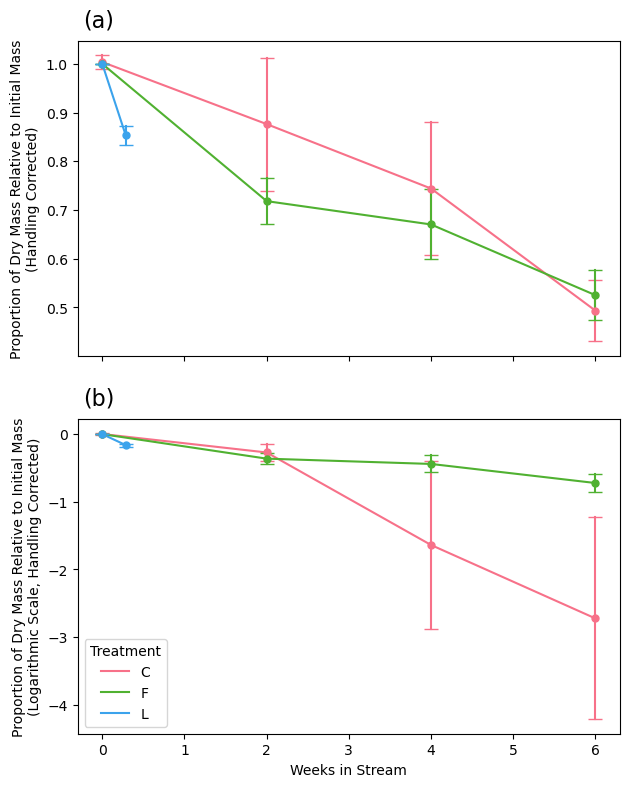

In [13]:
# Creating a figure with two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 9), sharex=True)

# Plotting the first graph on the top (ax1)
sns.lineplot(data=mass_mod_df, 
             x='Week', y='Corr_Proportion',
             hue='Treatment', palette='husl',err_style="bars", errorbar=("se", 2), err_kws=dict(fmt='o', markersize=5, capsize=5),
             ax=ax1)

ax1.set(title='',
        ylabel='Proportion of Dry Mass Relative to Initial Mass\n(Handling Corrected)')
ax1.text(0.01, 1.1, '(a)', transform=ax1.transAxes, fontsize=16, va='top')
ax1.get_legend().remove()  # Remove the legend from the first subplot

# Plotting the second graph on the bottom (ax2)
sns.lineplot(data=mass_mod_df, 
             x='Week', y='ln_Corr_Proportion',
             hue='Treatment', palette='husl',err_style="bars", errorbar=("se", 2), err_kws=dict(fmt='o', markersize=5, capsize=5),
             ax=ax2)

ax2.set(title='',
        xlabel='Weeks in Stream', ylabel='Proportion of Dry Mass Relative to Initial Mass\n(Logarithmic Scale, Handling Corrected)')
ax2.text(0.01, 1.1, '(b)', transform=ax2.transAxes, fontsize=16, va='top')


plt.show()

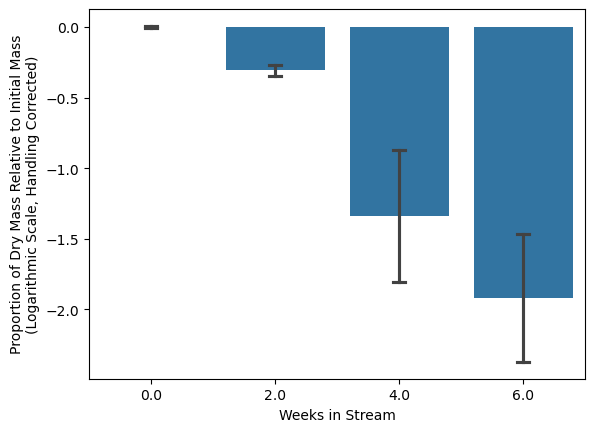

In [14]:
ax = sns.barplot(data=mass_mod_df[(mass_mod_df['Treatment']=='C')|(mass_mod_df['Treatment']=='F')], 
                 x='Week', y='ln_Corr_Proportion', 
                 errorbar=("se"),capsize=0.1 
                 #estimator='sum', errorbar=None
                )
ax.set(title='',
       xlabel='Weeks in Stream', ylabel='Proportion of Dry Mass Relative to Initial Mass\n(Logarithmic Scale, Handling Corrected)')
plt.show()

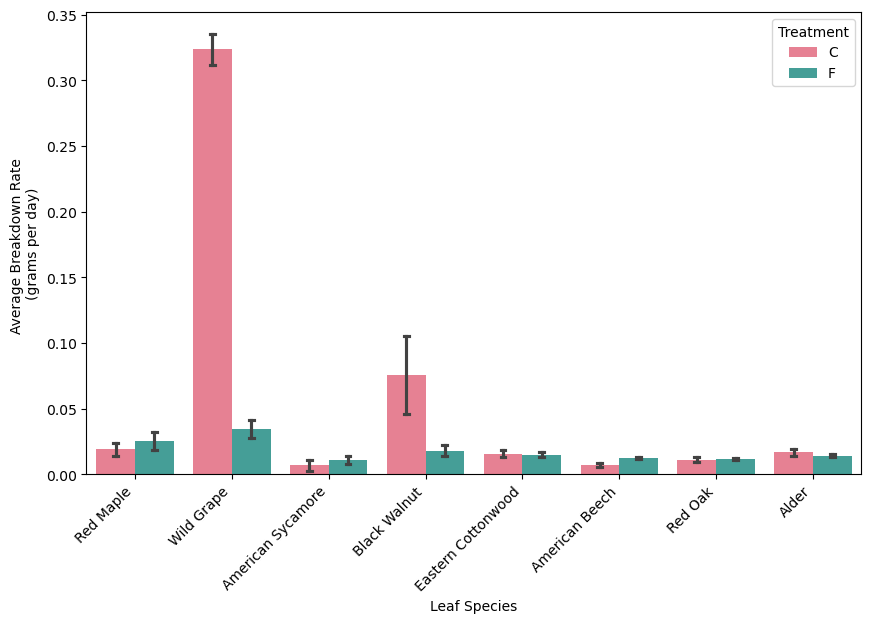

In [69]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the barplot
ax = sns.barplot(data=new_K_df, 
                 x='Species', y='K', hue='Treatment', 
                 palette='husl', 
                 errorbar=("se"), capsize=0.1)

# Set legend, title, and labels
ax.legend(title='Treatment')
ax.set(title='',
       xlabel='Leaf Species', ylabel='Average Breakdown Rate \n(grams per day)')

# Get current tick locations and labels
ticks = ax.get_xticks()
ticklabels = [label.get_text() for label in ax.get_xticklabels()]

# Set ticks and rotate and align x-axis labels
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels, rotation=45, ha='right')

# Show the plot
plt.show()


### ANOVA

#### Breakdown Rate Between Species and Treatment

In [77]:
model = ols('K ~ C(Species) + C(Treatment) + C(Treatment):C(Species)', data=new_K_df).fit() 
result = sm.stats.anova_lm(model, type=2) 
   
result

,df,sum_sq,mean_sq,F,PR(>F)
C(Species),7.0,0.141679,0.020240,88.588730,4.003876e-19
C(Treatment),1.0,0.020904,0.020904,91.497519,6.646614e-11
C(Treatment):C(Species),7.0,0.109458,0.015637,68.442043,1.910367e-17
Residual,32.0,0.007311,0.000228,NaN,NaN


#### Breakdown Rate Between Species

In [71]:
comp = mc.MultiComparison(new_K_df['K'], new_K_df['Species'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Alder,American Beech,-0.0057,1.0,-0.1139,0.1026,False
Alder,American Sycamore,-0.0065,1.0,-0.1147,0.1018,False
Alder,Black Walnut,0.0315,0.9813,-0.0768,0.1397,False
Alder,Eastern Cottonwood,-0.0001,1.0,-0.1083,0.1082,False
Alder,Red Maple,0.0066,1.0,-0.1017,0.1149,False
Alder,Red Oak,-0.0042,1.0,-0.1125,0.1041,False
Alder,Wild Grape,0.1636,0.0005,0.0554,0.2719,True
American Beech,American Sycamore,-0.0008,1.0,-0.1091,0.1075,False
American Beech,Black Walnut,0.0372,0.9538,-0.0711,0.1454,False
American Beech,Eastern Cottonwood,0.0056,1.0,-0.1027,0.1139,False


#### Breakdown Rate Between Treatment

In [72]:
comp = mc.MultiComparison(new_K_df['K'], new_K_df['Treatment'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
C,F,-0.0417,0.0599,-0.0853,0.0018,False


#### Breakdown Rate Between Species:Treatment

In [73]:
response = new_K_df['K']
group = new_K_df['Treatment'].astype(str) + "-" + new_K_df['Species']  

tukey_result = mc.pairwise_tukeyhsd(response, group)
tukey_result.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
C-Alder,C-American Beech,-0.0095,1.0,-0.0553,0.0362,False
C-Alder,C-American Sycamore,-0.01,1.0,-0.0557,0.0358,False
C-Alder,C-Black Walnut,0.0591,0.0031,0.0133,0.1049,True
C-Alder,C-Eastern Cottonwood,-0.001,1.0,-0.0468,0.0447,False
C-Alder,C-Red Maple,0.0022,1.0,-0.0436,0.0479,False
C-Alder,C-Red Oak,-0.0056,1.0,-0.0514,0.0402,False
C-Alder,C-Wild Grape,0.3068,0.0,0.2611,0.3526,True
C-Alder,F-Alder,-0.0026,1.0,-0.0483,0.0432,False
C-Alder,F-American Beech,-0.0044,1.0,-0.0502,0.0414,False
C-Alder,F-American Sycamore,-0.0055,1.0,-0.0513,0.0402,False


#### Proportion Left Between Weeks, Treatment and Species

In [17]:
model = ols('Corr_Proportion ~ C(Week) + C(Treatment) + C(Species) + C(Week):C(Treatment) + C(Week):C(Species) + C(Treatment):C(Species)+ C(Week):C(Treatment):C(Species)', data=mass_df).fit() 
result = sm.stats.anova_lm(model, type=2) 
  
result

,df,sum_sq,mean_sq,F,PR(>F)
C(Week),3.0,12.112569,4.037523,32.039327,1.651881e-18
C(Treatment),2.0,0.980386,0.490193,3.889875,2.125646e-02
C(Species),11.0,2.341581,0.212871,1.689215,7.364594e-02
C(Week):C(Treatment),6.0,1.191889,0.198648,1.576351,1.526948e-01
C(Week):C(Species),33.0,3.421788,0.103691,0.822825,7.472525e-01
C(Treatment):C(Species),22.0,2.387829,0.108538,0.861289,6.470007e-01
C(Week):C(Treatment):C(Species),66.0,25.340157,0.383942,3.046728,9.448049e-12
Residual,385.0,48.516824,0.126018,NaN,NaN


In [18]:
model = ols('ln_Corr_Proportion ~ C(Week) + C(Treatment) + C(Species) + C(Week):C(Treatment) + C(Week):C(Species) + C(Treatment):C(Species)+ C(Week):C(Treatment):C(Species)', data=mass_df).fit() 
result = sm.stats.anova_lm(model, type=2) 
  
result

,df,sum_sq,mean_sq,F,PR(>F)
C(Week),3.0,267.619286,89.206429,13.616586,1.845142e-08
C(Treatment),2.0,77.916615,38.958307,5.946647,2.860826e-03
C(Species),11.0,782.153971,71.104906,10.853546,1.677648e-17
C(Week):C(Treatment),6.0,644.086834,107.347806,16.385710,7.868781e-17
C(Week):C(Species),33.0,650.668046,19.717214,3.009661,1.897092e-07
C(Treatment):C(Species),22.0,390.898942,17.768134,2.712151,6.371094e-05
C(Week):C(Treatment):C(Species),66.0,1043.751976,15.814424,2.413934,1.001584e-07
Residual,385.0,2522.253007,6.551307,NaN,NaN


#### Proportion Left Between Weeks

In [19]:
comp = mc.MultiComparison(mass_df['ln_Corr_Proportion'], mass_df['Week'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,2,-0.2439,0.9401,-1.3415,0.8538,False
0,4,-1.2758,0.0253,-2.4401,-0.1116,True
0,6,-1.8537,0.0001,-2.9537,-0.7537,True
2,4,-1.032,0.1029,-2.1962,0.1323,False
2,6,-1.6098,0.001,-2.7098,-0.5099,True
4,6,-0.5778,0.5778,-1.7443,0.5886,False


#### Proportion Left Between Treatment

In [20]:
comp = mc.MultiComparison(mass_df['ln_Corr_Proportion'], mass_df['Treatment'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
C,F,0.6307,0.1967,-0.2287,1.4902,False
C,L,0.9908,0.1428,-0.242,2.2237,False
F,L,0.3601,0.8053,-0.9901,1.7103,False


#### Proportion Left Between Species

In [21]:
comp = mc.MultiComparison(mass_df['ln_Corr_Proportion'], mass_df['Species'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Alder,American Beech,0.1449,1.0,-1.7908,2.0806,False
Alder,American Beech,-0.3022,1.0,-10.7264,10.1219,False
Alder,American Sycamore,0.1356,1.0,-1.8087,2.08,False
Alder,Black Walnut,-0.6669,0.9934,-2.6112,1.2774,False
Alder,Eastern Cottonwood,-0.0343,1.0,-1.9876,1.9189,False
Alder,Eastern Cottonwood,0.3414,1.0,-5.7798,6.4627,False
Alder,Red Maple,-0.1572,1.0,-2.1104,1.796,False
Alder,Red Maple,-0.4332,1.0,-10.8574,9.9909,False
Alder,Red Oak,0.1136,1.0,-1.8583,2.0855,False
Alder,Red Oak,0.0427,1.0,-4.7772,4.8626,False


#### Proportion Left Between Weeks:Treatment

In [22]:
response = mass_df['ln_Corr_Proportion']
group = mass_df['Week'].astype(str) + "-" + mass_df['Treatment']  # Example for interaction

tukey_result = mc.pairwise_tukeyhsd(response, group)
tukey_result.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0-C,0-L,-0.1639,1.0,-2.016,1.6882,False
0-C,2-C,-0.2729,0.9997,-1.9295,1.3836,False
0-C,2-F,-0.3642,0.9989,-2.2163,1.4879,False
0-C,4-C,-1.641,0.0543,-3.2976,0.0156,False
0-C,4-F,-0.4426,0.9991,-2.7853,1.9001,False
0-C,6-C,-2.7269,0.0,-4.3893,-1.0645,True
0-C,6-F,-0.7246,0.9342,-2.5767,1.1275,False
0-L,2-C,-0.109,1.0,-1.9611,1.7431,False
0-L,2-F,-0.2003,1.0,-2.2291,1.8286,False
0-L,4-C,-1.4771,0.23,-3.3292,0.375,False


#### Proportion Left Between Weeks:Species

In [23]:
response = mass_df['ln_Corr_Proportion']
group = mass_df['Week'].astype(str) + "-" + mass_df['Species']  # Example for interaction

tukey_result = mc.pairwise_tukeyhsd(response, group)
tukey_result.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0-Alder,0-American Beech,0.041,1.0,-3.8564,3.9385,False
0-Alder,0-American Sycamore,0.0646,1.0,-3.9696,4.0989,False
0-Alder,0-Black Walnut,0.0575,1.0,-3.9767,4.0918,False
0-Alder,0-Eastern Cottonwood,-0.0444,1.0,-4.1606,4.0718,False
0-Alder,0-Eastern Cottonwood,0.1063,1.0,-6.8293,7.0418,False
0-Alder,0-Red Maple,0.0594,1.0,-3.9749,4.0936,False
0-Alder,0-Red Oak,0.0641,1.0,-3.8334,3.9615,False
0-Alder,0-Wild Grape,0.0156,1.0,-4.0187,4.0498,False
0-Alder,2-Alder,-0.1448,1.0,-4.1067,3.8171,False
0-Alder,2-American Beech,-0.0548,1.0,-4.0167,3.9071,False


#### Proportion Left Between Treatment:Species

In [24]:
response = mass_df['ln_Corr_Proportion']
group = mass_df['Treatment'].astype(str) + "-" + mass_df['Species']  # Example for interaction

tukey_result = mc.pairwise_tukeyhsd(response, group)
tukey_result.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
C-Alder,C-American Beech,0.181,1.0,-2.5317,2.8938,False
C-Alder,C-American Sycamore,0.1772,1.0,-2.5356,2.89,False
C-Alder,C-Black Walnut,-0.9962,0.9999,-3.709,1.7166,False
C-Alder,C-Eastern Cottonwood,-0.0331,1.0,-2.806,2.7398,False
C-Alder,C-Eastern Cottonwood,0.3335,1.0,-6.5414,7.2084,False
C-Alder,C-Red Maple,-0.1044,1.0,-2.8362,2.6274,False
C-Alder,C-Red Maple,-0.4412,1.0,-12.0313,11.1489,False
C-Alder,C-Red Oak,0.1062,1.0,-2.6065,2.819,False
C-Alder,C-Wild Grape,-5.9459,0.0,-8.6586,-3.2331,True
C-Alder,F-Alder,-0.0768,1.0,-3.6036,3.4499,False


#### Proportion Left Between Weeks:Treatment\:Species

In [25]:
response = mass_df['ln_Corr_Proportion']
group = mass_df['Week'].astype(str) + "-" + mass_df['Treatment']+ "-" + mass_df['Species']  # Example for interaction

tukey_result = mc.pairwise_tukeyhsd(response, group)
tukey_result.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0-C-Alder,0-C-American Beech,0.0009,1.0,-5.0472,5.049,False
0-C-Alder,0-C-American Sycamore,0.0019,1.0,-5.0461,5.05,False
0-C-Alder,0-C-Black Walnut,0.001,1.0,-5.0471,5.049,False
0-C-Alder,0-C-Eastern Cottonwood,0.0035,1.0,-5.6404,5.6475,False
0-C-Alder,0-C-Eastern Cottonwood,0.0072,1.0,-7.1319,7.1462,False
0-C-Alder,0-C-Red Maple,-0.0003,1.0,-5.0484,5.0478,False
0-C-Alder,0-C-Red Oak,-0.0002,1.0,-5.0483,5.0479,False
0-C-Alder,0-C-Wild Grape,0.0025,1.0,-5.0456,5.0506,False
0-C-Alder,0-L-Alder,-0.2265,1.0,-5.6231,5.1701,False
0-C-Alder,0-L-American Beech,-0.1339,1.0,-5.5305,5.2627,False


## Leaching

### Data Import

In [26]:
leacheate_df = pd.read_csv("Class_Leachate.csv")
leacheate_df

,Group,Species,Percent_remaining,Double_SE
0,1,Red Maple,0.833333,NaN
1,1,Wild Grape,0.813333,NaN
2,2,American Sycamore,0.937178,NaN
3,2,Black Walnut,1.040323,NaN
4,3,Red Maple,0.868419,NaN
5,3,Wild Grape,0.774221,NaN
6,4,American Sycamore,0.946667,NaN
7,4,Black Walnut,0.913621,NaN
8,5,American Beech,0.815534,NaN
9,5,Eastern Cottonwood,0.806667,NaN


In [27]:
leacheate_avg_df = leacheate_df.groupby('Species')['Percent_remaining'].mean()
leacheate_avg_df

Species
Alder                 0.799144
American Beech        0.868116
American Sycamore     0.915059
Black Walnut          0.924404
Eastern Cottonwood    0.830471
Red Maple             0.879103
Red Oak               0.926151
Wild Grape            0.797333
Name: Percent_remaining, dtype: float64

In [28]:
K_avg_df = K_df.groupby('Species')['K'].mean()
K_avg_df

Species
Alder                 0.015383
American Beech        0.074588
American Sycamore     0.006950
Black Walnut          0.034983
Eastern Cottonwood    0.067305
Red Maple             0.012995
Red Oak               0.011433
Wild Grape            0.067625
Name: K, dtype: float64

In [29]:
K_leacheate_df = pd.merge(K_avg_df, leacheate_avg_df, left_index=True, right_index=True)
K_leacheate_df

,K,Percent_remaining
Species,,
Alder,0.015383,0.799144
American Beech,0.074588,0.868116
American Sycamore,0.006950,0.915059
Black Walnut,0.034983,0.924404
Eastern Cottonwood,0.067305,0.830471
Red Oak,0.011433,0.926151


### Visualisation

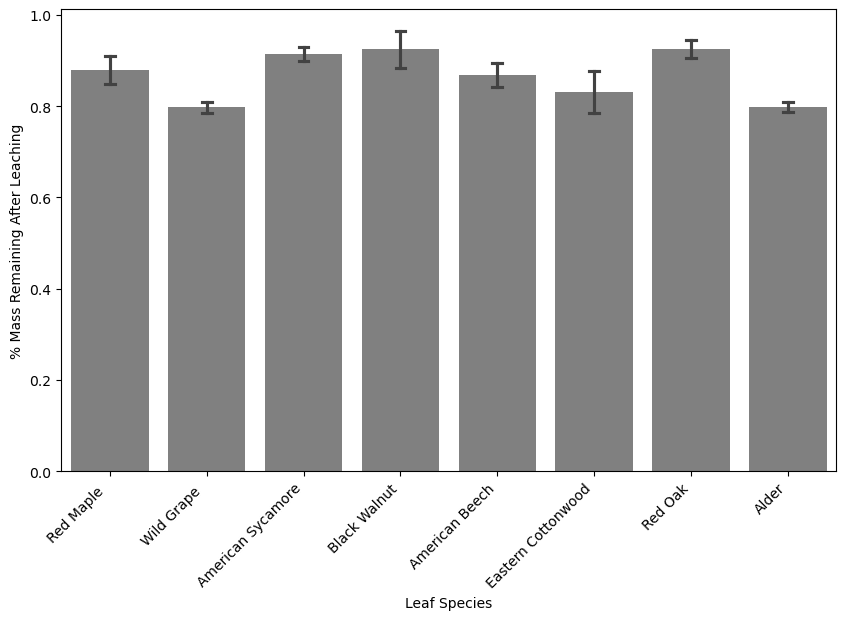

In [30]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=leacheate_df, 
                 x='Species', y='Percent_remaining',
                 errorbar=("se"),capsize=0.1, color='grey'
                 #estimator='sum', errorbar=None
                )
ax.set(title='',#Average % Mass Remaining of Leaves after Leaching
       xlabel='Leaf Species', ylabel='% Mass Remaining After Leaching')
# Get current tick locations and labels
ticks = ax.get_xticks()
ticklabels = [label.get_text() for label in ax.get_xticklabels()]

# Set ticks and rotate and align x-axis labels
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels, rotation=45, ha='right')

# Show the plot
plt.show()

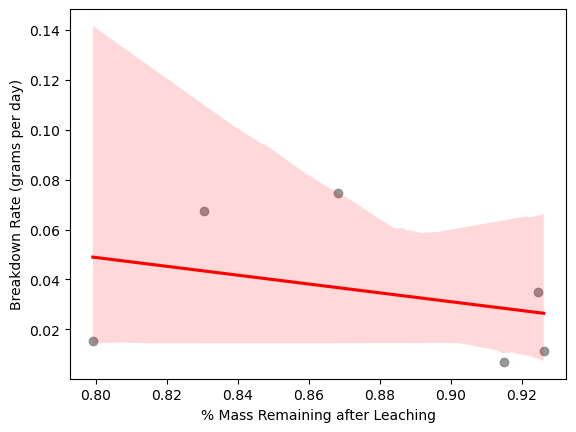

In [31]:
ax = sns.regplot(data=K_leacheate_df, x='Percent_remaining', y='K', color='grey', line_kws=dict(color='r'))
ax.set(title='',
       #Relationship between Breakdown Rates and % Mass Remaining after Leaching
       xlabel='% Mass Remaining after Leaching', ylabel='Breakdown Rate (grams per day)')
plt.show()

### t-Test

In [32]:
model = ols('K ~ Percent_remaining', data=K_leacheate_df).fit() 
model.summary()

/Users/stevenzhou/opt/anaconda3/envs/info2950/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      K   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                 -0.120
Method:                 Least Squares   F-statistic:                    0.4660
Date:                Wed, 06 Dec 2023   Prob (F-statistic):              0.532
Time:                        00:22:21   Log-Likelihood:                 13.513
No. Observations:                   6   AIC:                            -23.03
Df Residuals:                       4   BIC:                            -23.44
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1905      0.228      0.836      0.450      -0.443       0.824
Percent_remaining    -0.1772      0.260     -0.683      0.532      -0.898       0.543
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.899
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.551
Skew:                           0.177   Prob(JB):                        0.759
Kurtosis:                       1.558   Cond. No.                         36.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ANOVA

In [33]:
model = ols('Percent_remaining ~ C(Species)', data=leacheate_df).fit() 
result = sm.stats.anova_lm(model, type=2) 
   
result

,df,sum_sq,mean_sq,F,PR(>F)
C(Species),7.0,0.065211,0.009316,3.472872,0.015612
Residual,18.0,0.048285,0.002682,NaN,NaN


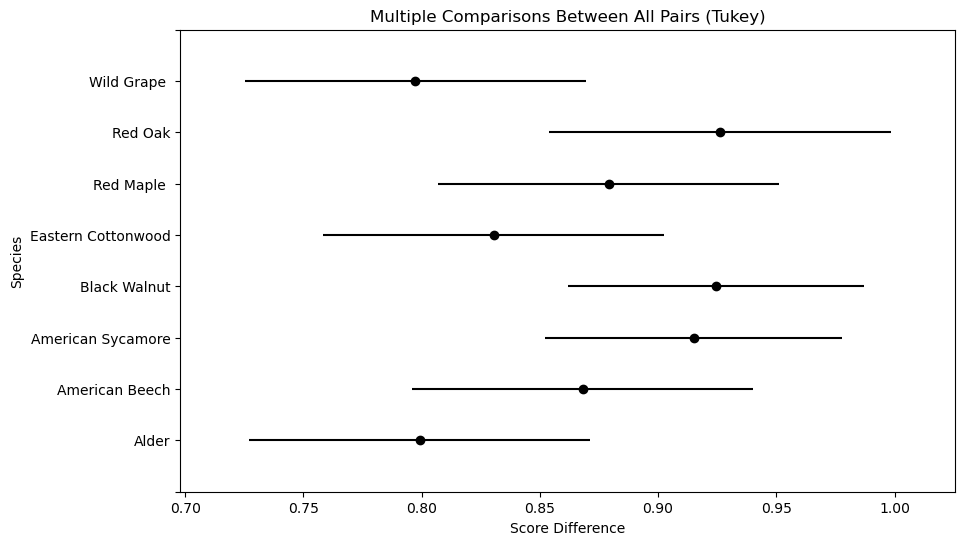

group1,group2,meandiff,p-adj,lower,upper,reject
Alder,American Beech,0.069,0.7273,-0.0753,0.2132,False
Alder,American Sycamore,0.1159,0.1239,-0.019,0.2509,False
Alder,Black Walnut,0.1253,0.0801,-0.0097,0.2602,False
Alder,Eastern Cottonwood,0.0313,0.9942,-0.1129,0.1756,False
Alder,Red Maple,0.08,0.5731,-0.0643,0.2242,False
Alder,Red Oak,0.127,0.1085,-0.0173,0.2713,False
Alder,Wild Grape,-0.0018,1.0,-0.1461,0.1424,False
American Beech,American Sycamore,0.0469,0.9257,-0.088,0.1819,False
American Beech,Black Walnut,0.0563,0.8354,-0.0787,0.1912,False
American Beech,Eastern Cottonwood,-0.0376,0.9833,-0.1819,0.1066,False


In [34]:
comp = mc.MultiComparison(leacheate_df['Percent_remaining'], 
                          leacheate_df['Species'])
post_hoc_res = comp.tukeyhsd()

post_hoc_res.plot_simultaneous(ylabel= "Species", xlabel= "Score Difference");
plt.show()

post_hoc_res.summary()

## Invertebrates

### Data Import and Cleaning

In [35]:
invert_df = pd.read_csv("Class_invert.csv")
invert_df['Count'] = invert_df['Count'].astype(np.int64)

def reclass_treat(o):
    if o == 'c':
        return 'C'
    return o
invert_df['Treatment'] = invert_df['Treatment'].apply(reclass_treat)

def reclass_FFG(o):
    if o == 'GG':
        return 'CG'
    elif o == 'S':
        return 'SC'
    return o
invert_df['FFG'] = invert_df['FFG'].apply(reclass_FFG)

invert_df

,Group,Lab,Leaf_Species,Week,Treatment,Replicate,Order,Family,Genus,FFG,Count
0,3,T,Red Maple,0,C,NaN,Ephemeroptera,Heptageniidae,Macdunnoa,CG,2
1,3,T,Red Maple,2,C,NaN,Trichoptera,Glossosomatidae,Glossosoma,CF,1
2,3,T,Red Maple,4,C,NaN,Trichoptera,Limnephilidae,Goera,CF,1
3,3,T,Red Maple,4,C,NaN,Ephemeroptera,Heptageniidae,Macdunnoa,CG,2
4,2,T,American Sycamore,4,C,1.0,Trichoptera,Philopotamidae,Chimarra,CF,1
...,...,...,...,...,...,...,...,...,...,...,...
491,11,W,Eastern Cottonwood,6,C,3.0,Plecoptera,Leuctridae,Leuctra,SH,8
492,11,W,Eastern Cottonwood,6,C,3.0,Plecoptera,Capniidae,Allocapnia,SH,5
493,11,W,Eastern Cottonwood,6,C,3.0,Diptera,Chironomidae,NaN,CG,1
494,11,W,Eastern Cottonwood,6,C,3.0,Plecoptera,Perlodidae,Isoperla,P,3


In [36]:
invert_sum_df = duckdb.sql("""SELECT "Group", Leaf_Species, Week, Treatment, Sum(Count) as Count
                                    FROM invert_df
                                    GROUP BY "Group", Leaf_Species, Week, Treatment""").df()
invert_sum_df

,Group,Leaf_Species,Week,Treatment,Count
0,3,Red Maple,0,C,2.0
1,3,Red Maple,2,C,1.0
2,3,Red Maple,4,C,3.0
3,2,American Sycamore,4,C,3.0
4,2,American Sycamore,2,C,1.0
...,...,...,...,...,...
75,5,Eastern Cottonwood,6,C,32.0
76,5,Eastern Cottonwood,6,F,19.0
77,7,Wild Grape,2,C,4.0
78,9,Red Oak,6,F,3.0


In [37]:
invert_unique_df = duckdb.sql("""SELECT "Group", Leaf_Species, Week, Treatment, FFG, Sum(Count) as Count
                                    FROM invert_df
                                    GROUP BY "Group", Leaf_Species, Week, Treatment, FFG""").df()
invert_unique_df

,Group,Leaf_Species,Week,Treatment,FFG,Count
0,3,Red Maple,0,C,CG,2.0
1,3,Red Maple,2,C,CF,1.0
2,3,Red Maple,4,C,CF,1.0
3,3,Red Maple,4,C,CG,2.0
4,2,American Sycamore,4,C,CF,1.0
...,...,...,...,...,...,...
239,8,Black Walnut,2,C,CG,2.0
240,8,Black Walnut,2,C,SC,1.0
241,11,American Beech,6,C,P,6.0
242,9,Red Oak,6,F,P,3.0


In [38]:
invert_genera_richness_df = duckdb.sql("""SELECT Leaf_Species, Treatment, Week, "Group", COUNT(DISTINCT Genus) AS Genera_Richness
                                            FROM invert_df
                                            GROUP BY Leaf_Species, Treatment, Week, "Group" """).df()
invert_genera_richness_df

,Leaf_Species,Treatment,Week,Group,Genera_Richness
0,Red Maple,C,0,3,1
1,Red Maple,C,2,3,1
2,Red Maple,C,4,3,2
3,American Sycamore,C,4,2,3
4,American Sycamore,C,2,2,1
...,...,...,...,...,...
75,American Beech,C,6,11,11
76,Eastern Cottonwood,C,2,11,2
77,Eastern Cottonwood,F,2,11,1
78,Eastern Cottonwood,C,4,11,4


In [39]:
invert_sum_trans_df = invert_sum_df.copy()
invert_sum_trans_df['sqrt_Count'] = np.sqrt(invert_sum_trans_df['Count'])
invert_sum_trans_df['log_Count'] = np.log(invert_sum_trans_df['Count']+1)

In [80]:
invert_genera_richness_trans_df = invert_genera_richness_df.copy()
invert_genera_richness_trans_df['sqrt_Genera_Richness'] = np.sqrt(invert_genera_richness_trans_df['Genera_Richness'])
invert_genera_richness_trans_df['log_Genera_Richness'] = np.log(invert_genera_richness_trans_df['Genera_Richness']+1)

### Visualisation

#### Abundance

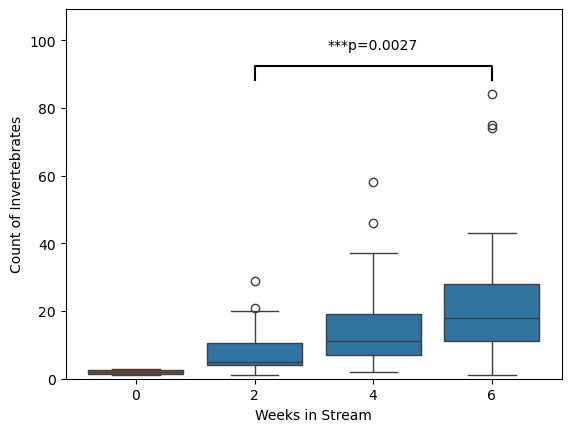

In [40]:
ax = sns.boxplot(data=invert_sum_df, x='Week', y='Count')
ax.set(xlabel='Weeks in Stream', ylabel='Count of Invertebrates')

# Determine the current maximum on the y-axis and increase it
y_max = invert_sum_df['Count'].max()
ax.set_ylim(0, y_max * 1.3)  # Increase the y-axis upper limit by 20%

# Adding annotation for the significant difference
# Coordinates for the start and end points of the line
x1, x2 = 1, 3 
y, h, col = y_max * 1.05, y_max * 0.05, 'k'  # Adjust the height and position of the line

# Draw line and text
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+h, "***p=0.0027", ha='center', va='bottom', color=col)

# Show the plot
plt.show()

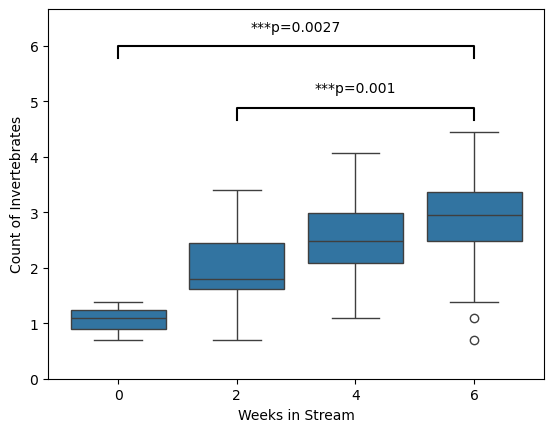

In [41]:
ax = sns.boxplot(data=invert_sum_trans_df, 
                 x='Week', y='log_Count', 
                 #err_kws={'fmt': 'o', 'markersize': 8, 'capsize': 5}
                )
ax.set(title='',
       xlabel='Weeks in Stream', ylabel='Count of Invertebrates')

# Determine the current maximum on the y-axis and increase it
y_max = invert_sum_trans_df['log_Count'].max()
ax.set_ylim(0, y_max * 1.5)  # Increase the y-axis upper limit by 20%

# Adding annotation for the significant difference
# Coordinates for the start and end points of the line
y1, y2, h, col = y_max * 1.05, y_max * 1.3, y_max * 0.05, 'k'  # Adjust the height and position of the line

# Draw line and text
plt.plot([1, 1, 3, 3], [y1, y1+h, y1+h, y1], lw=1.5, c=col)
plt.text((1+3)*.5, y1+h+h, "***p=0.001", ha='center', va='bottom', color=col)

# Draw line and text
plt.plot([0, 0, 3, 3], [y2, y2+h, y2+h, y2], lw=1.5, c=col)
plt.text((0+3)*.5, y2+h+h, "***p=0.0027", ha='center', va='bottom', color=col)

plt.show()

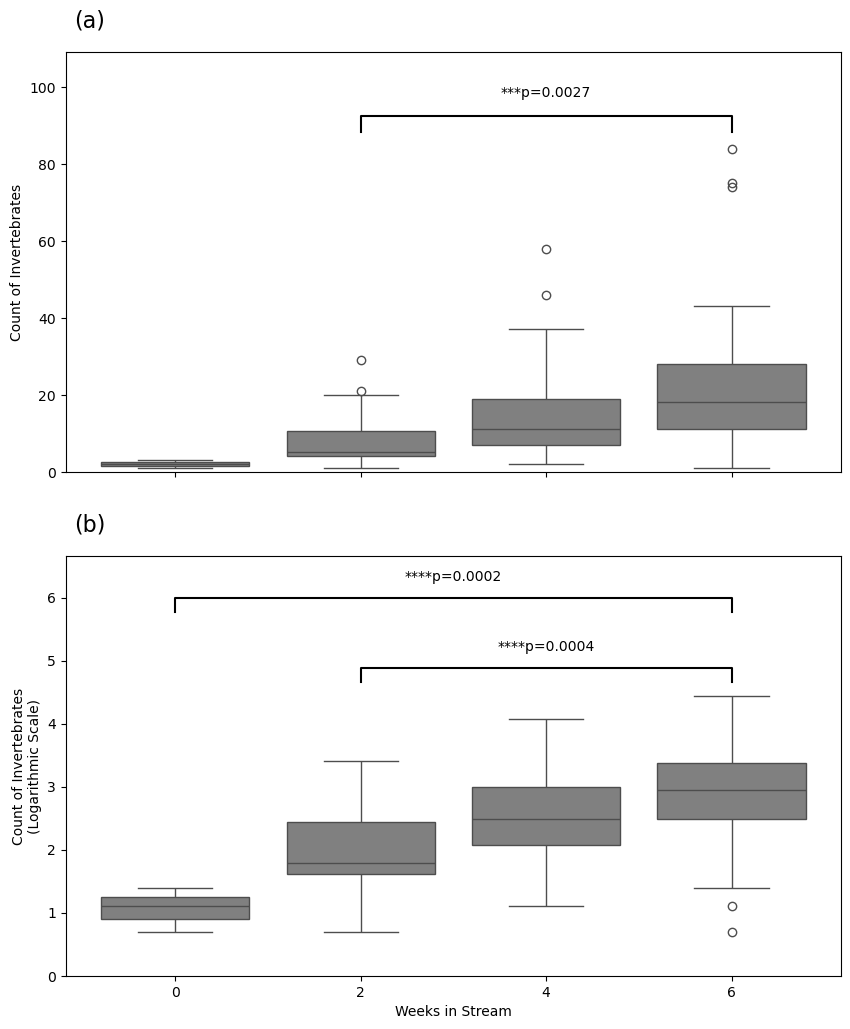

In [42]:
# Creating a figure with two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Plotting the first graph (ax1)
sns.boxplot(data=invert_sum_df, x='Week', y='Count', ax=ax1, color='grey')
ax1.set(xlabel='Weeks in Stream', ylabel='Count of Invertebrates')
y_max = invert_sum_df['Count'].max()
ax1.set_ylim(0, y_max * 1.3)

# Adding annotation for the significant difference
x1, x2 = 1, 3
y, h, col = y_max * 1.05, y_max * 0.05, 'k'
ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x1+x2)*.5, y+h+h, "***p=0.0027", ha='center', va='bottom', color=col)
ax1.text(0.01, 1.1, '(a)', transform=ax1.transAxes, fontsize=16, va='top')

# Plotting the second graph (ax2)
sns.boxplot(data=invert_sum_trans_df, x='Week', y='log_Count', ax=ax2, color='grey')
ax2.set(title='', xlabel='Weeks in Stream', ylabel='Count of Invertebrates\n(Logarithmic Scale)')
y_max_trans = invert_sum_trans_df['log_Count'].max()
ax2.set_ylim(0, y_max_trans * 1.5)

# Adding annotation for the significant difference
y1, y2, h, col = y_max_trans * 1.05, y_max_trans * 1.3, y_max_trans * 0.05, 'k'
ax2.plot([1, 1, 3, 3], [y1, y1+h, y1+h, y1], lw=1.5, c=col)
ax2.text((1+3)*.5, y1+h+h, "****p=0.0004", ha='center', va='bottom', color=col)
ax2.plot([0, 0, 3, 3], [y2, y2+h, y2+h, y2], lw=1.5, c=col)
ax2.text((0+3)*.5, y2+h+h, "****p=0.0002", ha='center', va='bottom', color=col)
ax2.text(0.01, 1.1, '(b)', transform=ax2.transAxes, fontsize=16, va='top')

plt.show()

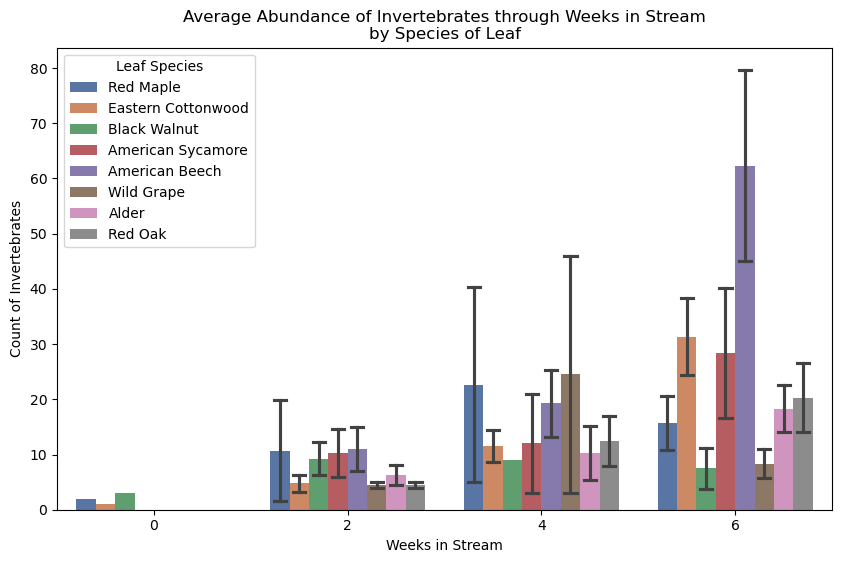

In [43]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=invert_sum_df, 
                 x='Week', y='Count', hue='Leaf_Species', 
                 palette='deep', 
                 errorbar=("se"), capsize=0.5
                 #err_kws={'fmt': 'o', 'markersize': 8, 'capsize': 5}
                )
ax.legend(title='Leaf Species')
ax.set(title='Average Abundance of Invertebrates through Weeks in Stream\nby Species of Leaf',
       xlabel='Weeks in Stream', ylabel='Count of Invertebrates')
plt.show()

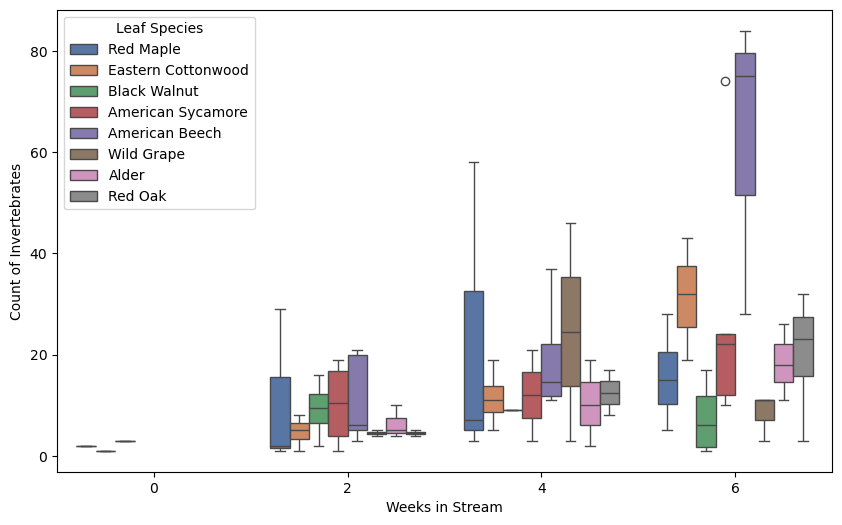

In [44]:
# Box Plot of Abundance of Invertebrates through Weeks in Stream\nby Species of Leaf
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=invert_sum_df, 
                 x='Week', y='Count', hue='Leaf_Species', 
                 palette='deep', 
                )
ax.legend(title='Leaf Species')
ax.set(title='',
       xlabel='Weeks in Stream', ylabel='Count of Invertebrates')
plt.show()

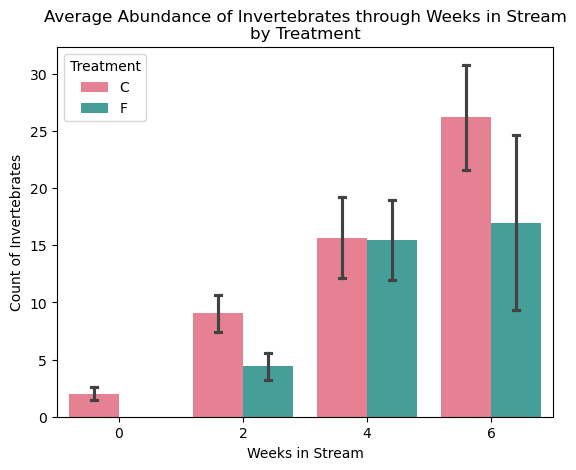

In [45]:
ax = sns.barplot(data=invert_sum_df, 
                 x='Week', y='Count', hue='Treatment', 
                 palette='husl', 
                 errorbar=("se"),capsize=0.1 
                 #estimator='sum', errorbar=None
                )
ax.legend(title='Treatment')
ax.set(title='Average Abundance of Invertebrates through Weeks in Stream\nby Treatment',
       xlabel='Weeks in Stream', ylabel='Count of Invertebrates')
plt.show()

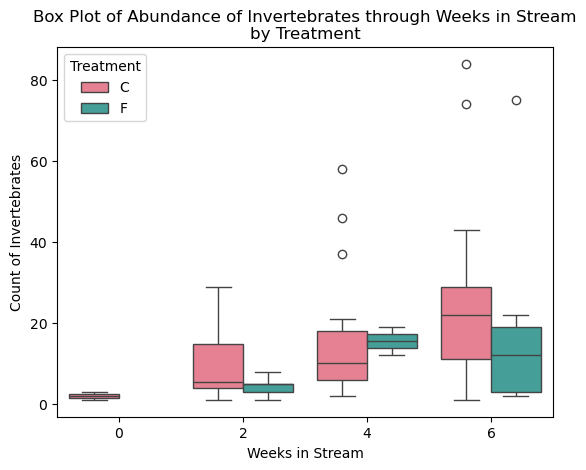

In [46]:
ax = sns.boxplot(data=invert_sum_df, 
                 x='Week', y='Count', hue='Treatment', 
                 palette='husl', 
                 #estimator='sum', errorbar=None
                )
ax.legend(title='Treatment')
ax.set(title='Box Plot of Abundance of Invertebrates through Weeks in Stream\nby Treatment',
       xlabel='Weeks in Stream', ylabel='Count of Invertebrates')
plt.show()

#### Richness

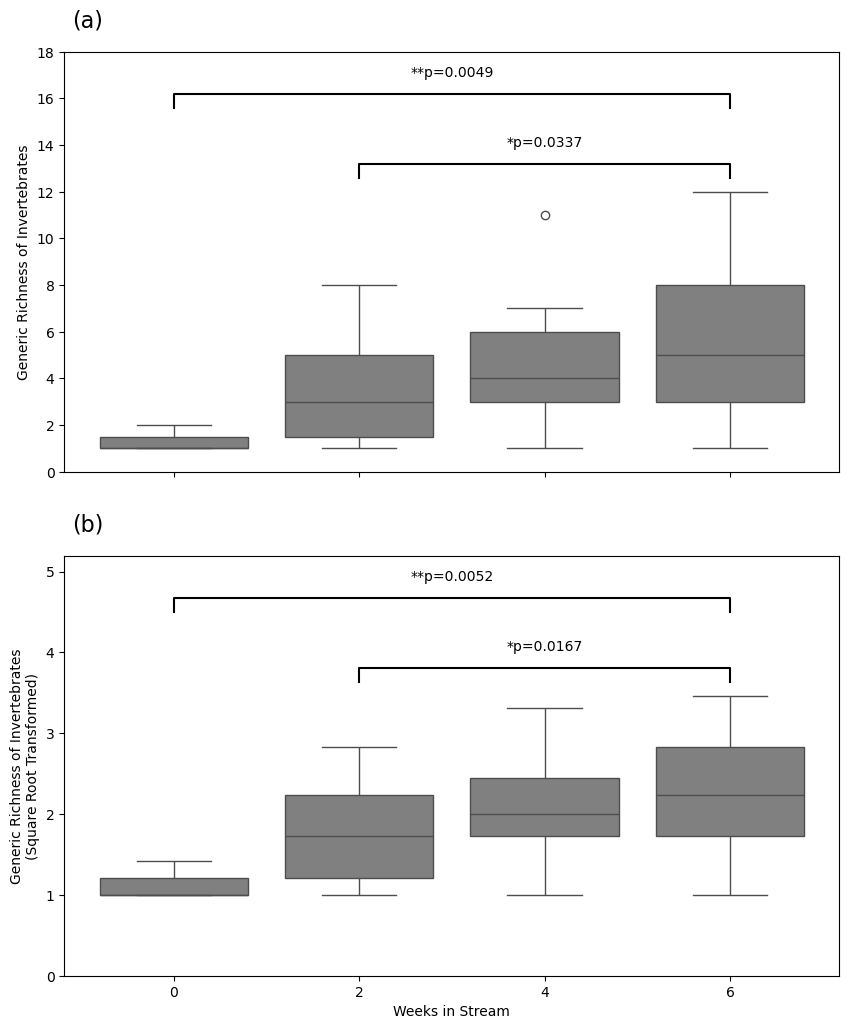

In [112]:
# Creating a figure with two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Plotting the first graph (ax1)
sns.boxplot(data=invert_genera_richness_df, x='Week', y='Genera_Richness', ax=ax1, color='grey')
ax1.set(xlabel='Weeks in Stream', ylabel='Generic Richness of Invertebrates')
y_max = invert_genera_richness_df['Genera_Richness'].max()
ax1.set_ylim(0, y_max * 1.5)

# Adding annotation for the significant difference
y1, y2, h, col = y_max * 1.05, y_max * 1.3, y_max * 0.05, 'k'
ax1.plot([1, 1, 3, 3], [y1, y1+h, y1+h, y1], lw=1.5, c=col)
ax1.text((1+3)*.5, y1+h+h, "*p=0.0337", ha='center', va='bottom', color=col)
ax1.plot([0, 0, 3, 3], [y2, y2+h, y2+h, y2], lw=1.5, c=col)
ax1.text((0+3)*.5, y2+h+h, "**p=0.0049", ha='center', va='bottom', color=col)
ax1.text(0.01, 1.1, '(a)', transform=ax1.transAxes, fontsize=16, va='top')

# Plotting the second graph (ax2)
sns.boxplot(data=invert_genera_richness_trans_df, x='Week', y='sqrt_Genera_Richness', ax=ax2, color='grey')
ax2.set(title='', xlabel='Weeks in Stream', ylabel='Generic Richness of Invertebrates\n(Square Root Transformed)')
y_max_trans = invert_genera_richness_trans_df['sqrt_Genera_Richness'].max()
ax2.set_ylim(0, y_max_trans * 1.5)

# Adding annotation for the significant difference
y1, y2, h, col = y_max_trans * 1.05, y_max_trans * 1.3, y_max_trans * 0.05, 'k'
ax2.plot([1, 1, 3, 3], [y1, y1+h, y1+h, y1], lw=1.5, c=col)
ax2.text((1+3)*.5, y1+h+h, "*p=0.0167", ha='center', va='bottom', color=col)
ax2.plot([0, 0, 3, 3], [y2, y2+h, y2+h, y2], lw=1.5, c=col)
ax2.text((0+3)*.5, y2+h+h, "**p=0.0052", ha='center', va='bottom', color=col)
ax2.text(0.01, 1.1, '(b)', transform=ax2.transAxes, fontsize=16, va='top')

plt.show()

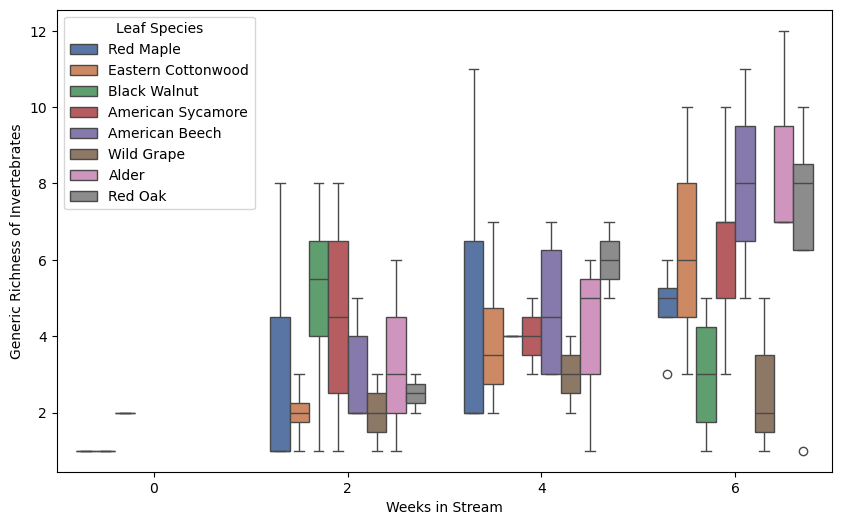

In [47]:
#Box Plot of Generic Richness of Invertebrates through Weeks in Stream\nby Species of Leaf
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=invert_genera_richness_df, 
                 x='Week', y='Genera_Richness', hue='Leaf_Species', 
                 palette='deep', 
                )
ax.legend(title='Leaf Species')
ax.set(title='',
       xlabel='Weeks in Stream', ylabel='Generic Richness of Invertebrates')
plt.show()

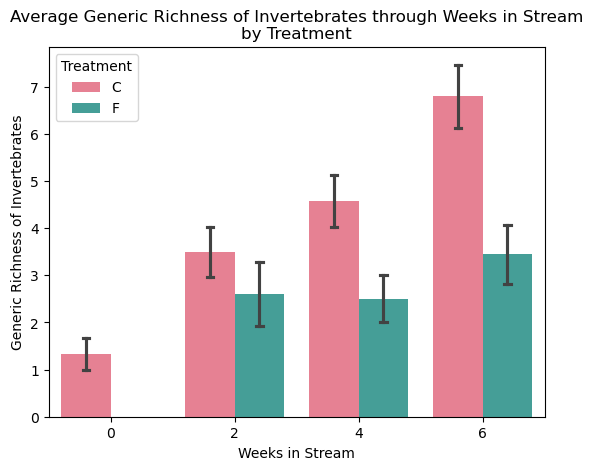

In [48]:
ax = sns.barplot(data=invert_genera_richness_df, 
                 x='Week', y='Genera_Richness', hue='Treatment', 
                 palette='husl', 
                 errorbar=("se"),capsize=0.1 
                 #estimator='sum', errorbar=None
                )
ax.legend(title='Treatment')
ax.set(title='Average Generic Richness of Invertebrates through Weeks in Stream\nby Treatment',
       xlabel='Weeks in Stream', ylabel='Generic Richness of Invertebrates')
plt.show()

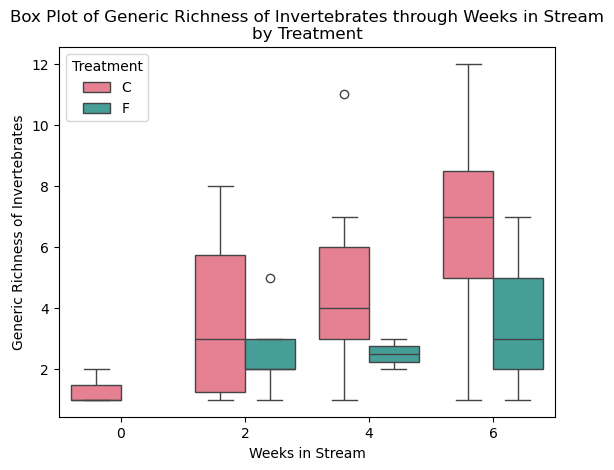

In [49]:
ax = sns.boxplot(data=invert_genera_richness_df, 
                 x='Week', y='Genera_Richness', hue='Treatment', 
                 palette='husl', 
                )
ax.legend(title='Treatment')
ax.set(title='Box Plot of Generic Richness of Invertebrates through Weeks in Stream\nby Treatment',
       xlabel='Weeks in Stream', ylabel='Generic Richness of Invertebrates')
plt.show()

Text(0.5, 1.02, 'Average Generic Richness of Invertebrates Through Days in Stream by Treatment')

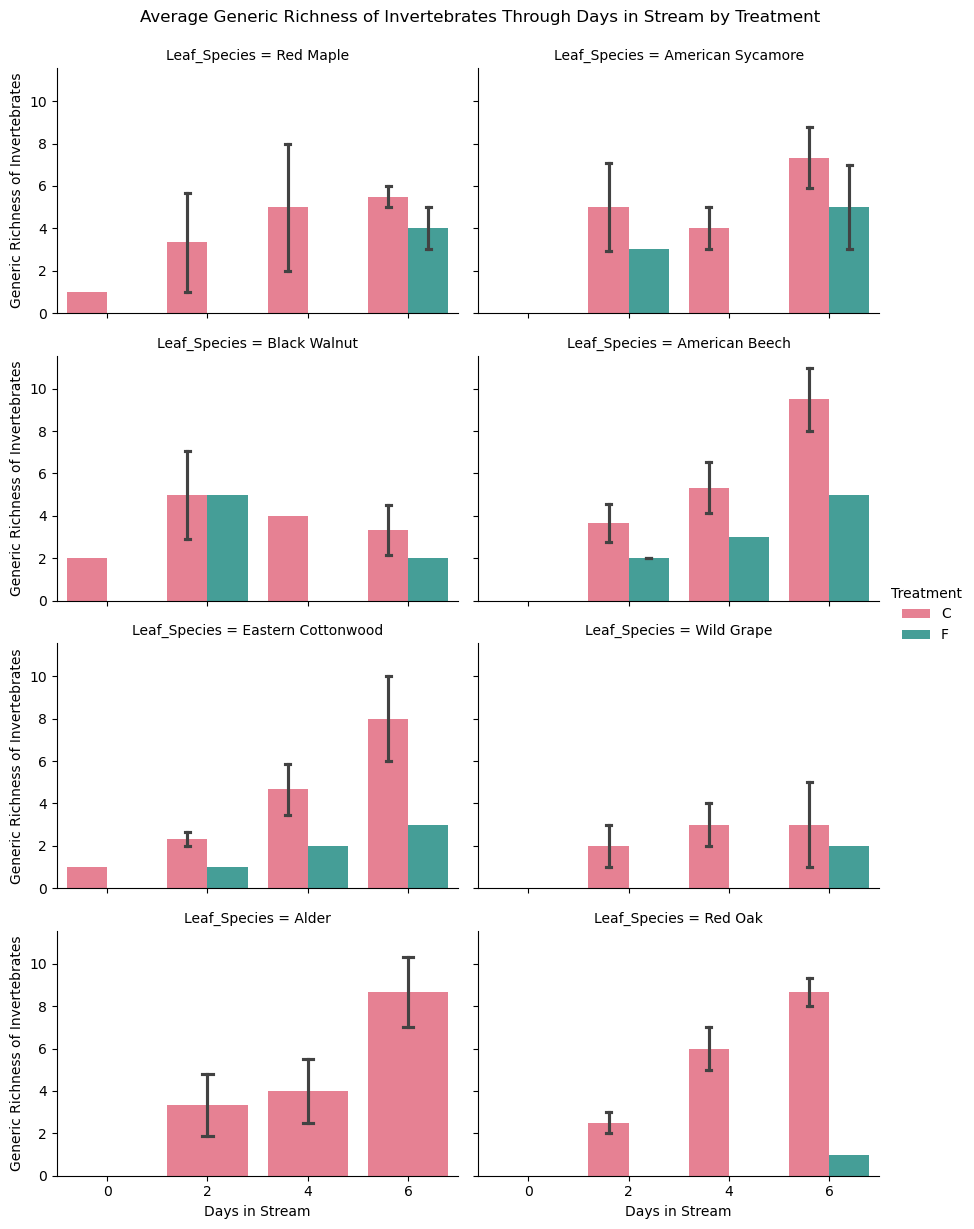

In [50]:
g = sns.FacetGrid(data=invert_genera_richness_df, 
                  col='Leaf_Species', col_wrap=2, 
                  height=3, aspect=1.5)
g.map_dataframe(sns.barplot, 
                x='Week', y='Genera_Richness', 
                hue='Treatment', hue_order=['C', 'F'], 
                palette='husl', errorbar=("se"),capsize=0.1 )

g.tight_layout()
g.set_axis_labels("Days in Stream", "Generic Richness of Invertebrates")
g.add_legend(title='Treatment')
plt.suptitle("Average Generic Richness of Invertebrates Through Days in Stream by Treatment", y=1.02)

Text(0.5, 1.02, 'Box Plot of Generic Richness of Invertebrates Through Days in Stream by Treatment')

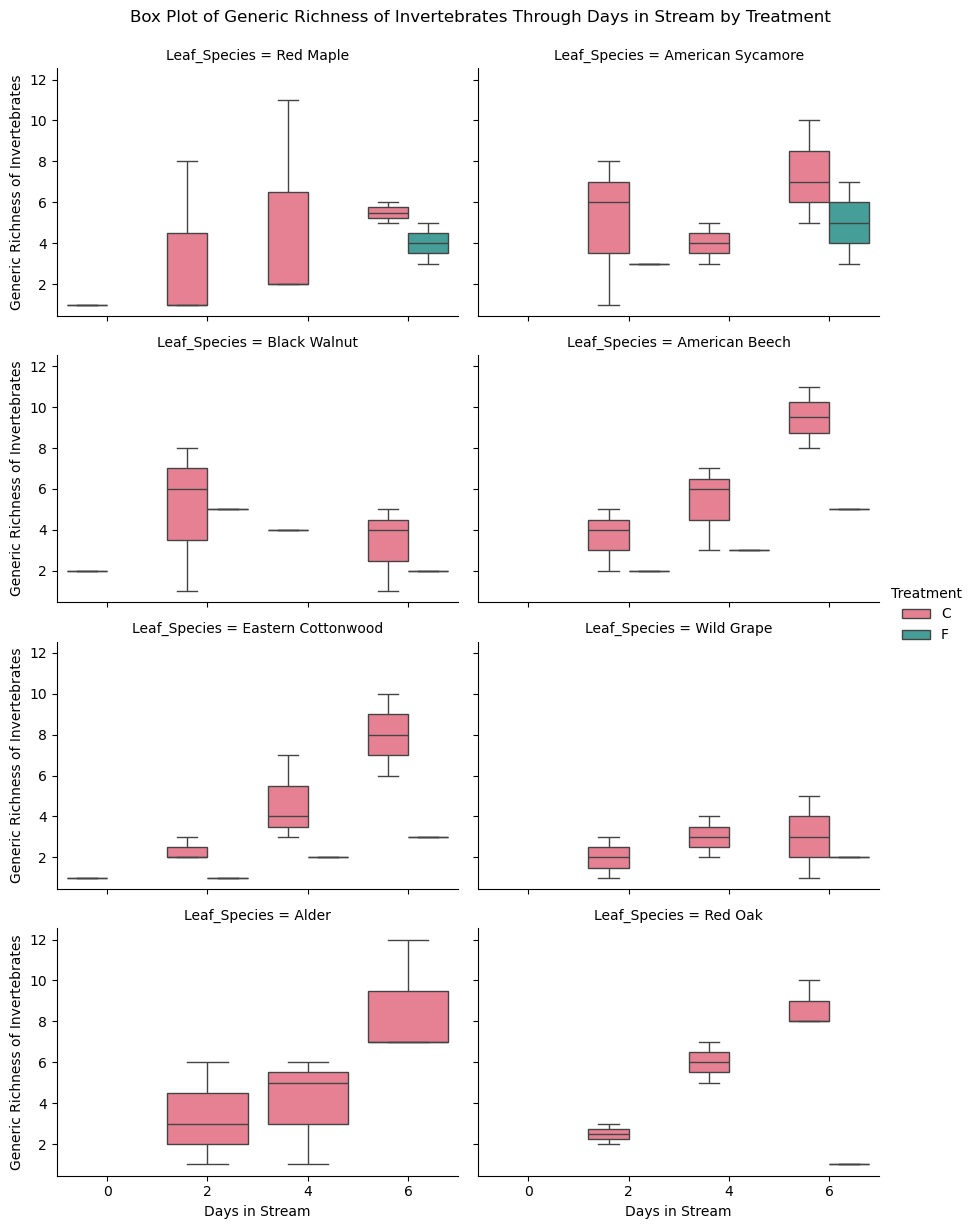

In [51]:
g = sns.FacetGrid(data=invert_genera_richness_df, 
                  col='Leaf_Species', col_wrap=2, 
                  height=3, aspect=1.5)
g.map_dataframe(sns.boxplot, 
                x='Week', y='Genera_Richness', 
                hue='Treatment', hue_order=['C', 'F'], 
                palette='husl', )

g.tight_layout()
g.set_axis_labels("Days in Stream", "Generic Richness of Invertebrates")
g.add_legend(title='Treatment')
plt.suptitle("Box Plot of Generic Richness of Invertebrates Through Days in Stream by Treatment", y=1.02)

#### FFGs

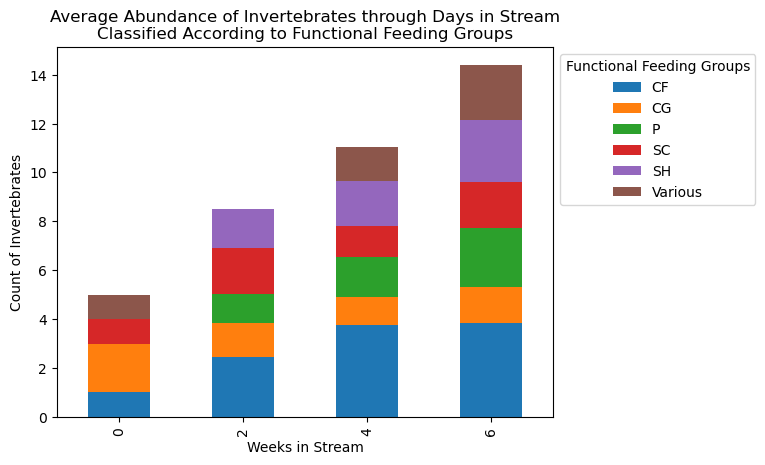

In [115]:
data = invert_df[invert_df['Treatment']=='C']

# Create a pivot table for the data
pivot_data = data.pivot_table(index='Week', columns='FFG', values='Count', fill_value=0)

# Plotting
ax = pivot_data.plot(kind='bar', stacked=True)

# Set titles and labels
ax.set_title('Average Abundance of Invertebrates through Days in Stream\nClassified According to Functional Feeding Groups')
ax.set_xlabel('Weeks in Stream')
ax.set_ylabel('Count of Invertebrates')
ax.legend(title='Functional Feeding Groups', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

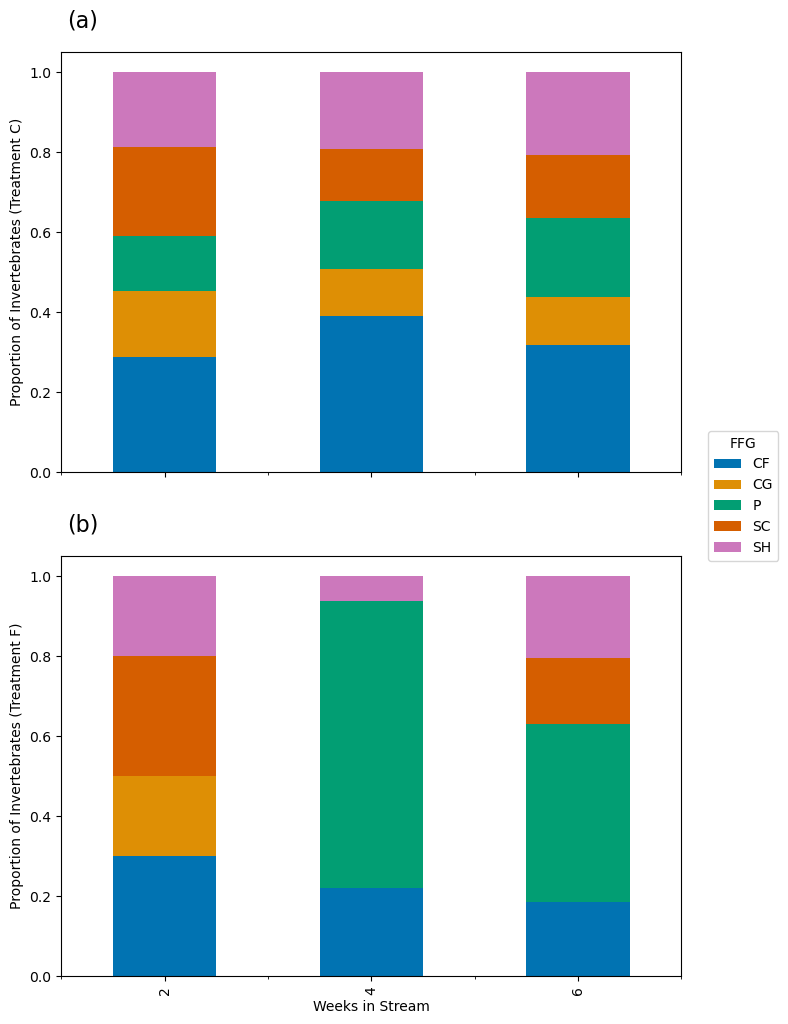

In [190]:
# Pivot tables and normalization
pivot_data_c = invert_df[((invert_df['Treatment'] == 'C') & (invert_df['FFG'] != 'Various')) & (invert_df['Week'] != 0)].pivot_table(index='Week', columns='FFG', values='Count', fill_value=0)
pivot_data_normalized_c = pivot_data_c.div(pivot_data_c.sum(axis=1), axis=0)

pivot_data_f = invert_df[((invert_df['Treatment'] == 'F') & (invert_df['FFG'] != 'Various')) & (invert_df['Week'] != 0)].pivot_table(index='Week', columns='FFG', values='Count', fill_value=0)
pivot_data_normalized_f = pivot_data_f.div(pivot_data_f.sum(axis=1), axis=0)

# Define a color palette
palette = sns.color_palette("colorblind", n_colors=len(pivot_data_c.columns))

# Create a mapping of FFG categories to colors
ffg_colors = dict(zip(pivot_data_c.columns, palette))

# Plotting with the defined color palette
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12), sharex=True)

pivot_data_normalized_c.plot(kind='bar', stacked=True, color=[ffg_colors[ffg] for ffg in pivot_data_normalized_c.columns], ax=ax1, legend=False)
ax1.set_ylabel('Proportion of Invertebrates (Treatment C)')
ax1.text(0.01, 1.1, '(a)', transform=ax1.transAxes, fontsize=16, va='top')

pivot_data_normalized_f.plot(kind='bar', stacked=True, color=[ffg_colors[ffg] for ffg in pivot_data_normalized_c.columns], ax=ax2, legend=False)
ax2.set_xlabel('Weeks in Stream')
ax2.set_ylabel('Proportion of Invertebrates (Treatment F)')
ax2.text(0.01, 1.1, '(b)', transform=ax2.transAxes, fontsize=16, va='top')

# Create a shared legend for the entire figure
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, title='FFG', bbox_to_anchor=(1.03, 0.57))

plt.show()

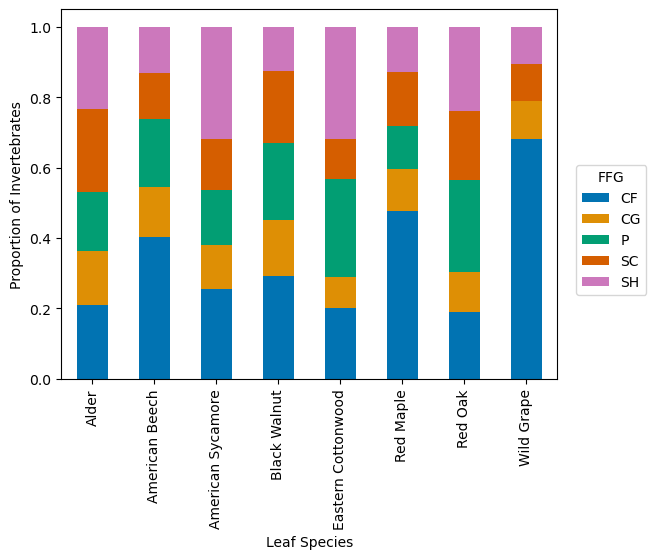

In [186]:
# Pivot tables and normalization
pivot_data_c = invert_df[((invert_df['Treatment'] == 'C') & (invert_df['FFG'] != 'Various')) & (invert_df['Week'] != 0)].pivot_table(index='Leaf_Species', columns='FFG', values='Count', fill_value=0)
pivot_data_normalized_c = pivot_data_c.div(pivot_data_c.sum(axis=1), axis=0)

# Define a color palette
palette = sns.color_palette("colorblind", n_colors=len(pivot_data_c.columns))

# Create a mapping of FFG categories to colors
ffg_colors = dict(zip(pivot_data_c.columns, palette))

# Plotting with the defined color palette
fig, ax1 = plt.subplots()

pivot_data_normalized_c.plot(kind='bar', stacked=True, color=[ffg_colors[ffg] for ffg in pivot_data_normalized_c.columns], ax=ax1, legend=False)
ax1.set_ylabel('Proportion of Invertebrates')
ax1.set_xlabel('Leaf Species')

# Create a shared legend for the entire figure
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, title='FFG', bbox_to_anchor=(1.05, 0.57))

plt.show()

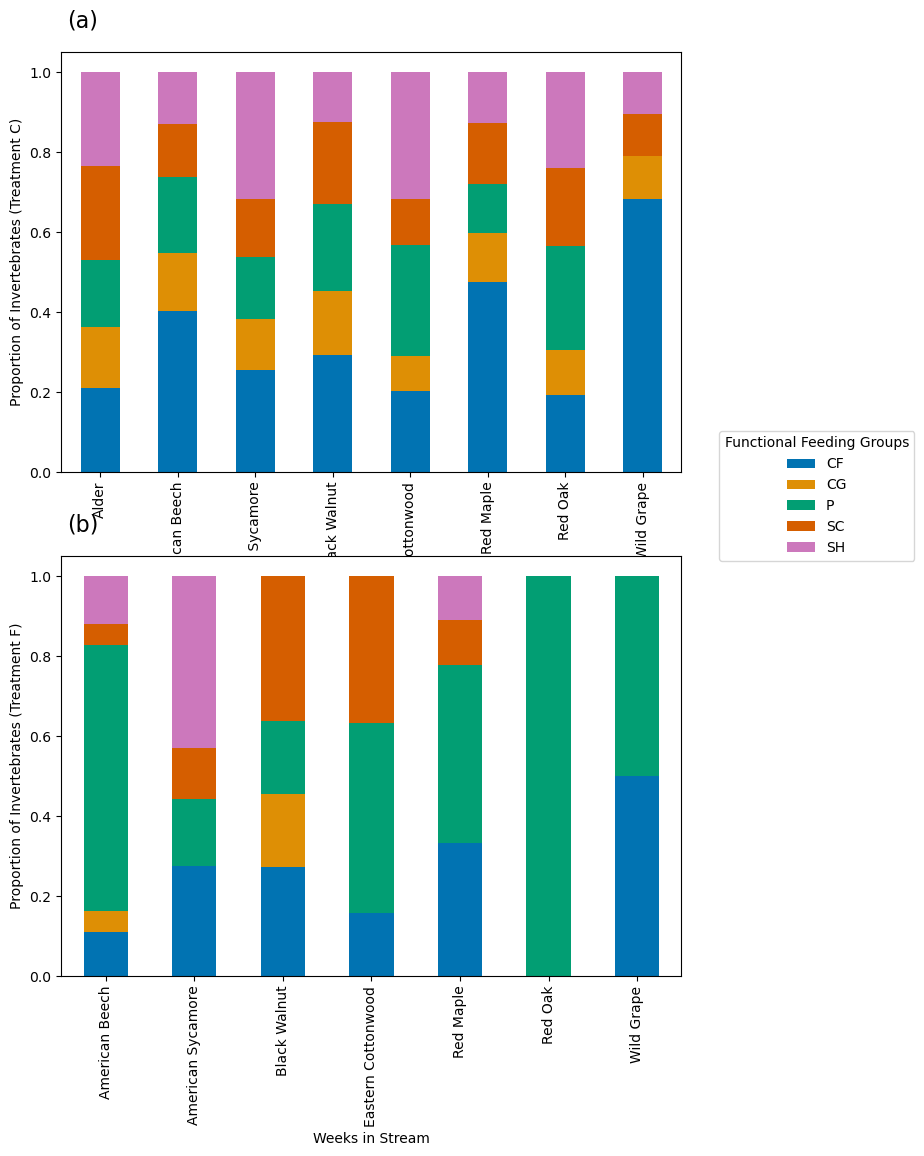

In [181]:
# Pivot tables and normalization
pivot_data_c = invert_df[((invert_df['Treatment'] == 'C') & (invert_df['FFG'] != 'Various')) & (invert_df['Week'] != 0)].pivot_table(index='Leaf_Species', columns='FFG', values='Count', fill_value=0)
pivot_data_normalized_c = pivot_data_c.div(pivot_data_c.sum(axis=1), axis=0)

pivot_data_f = invert_df[((invert_df['Treatment'] == 'F') & (invert_df['FFG'] != 'Various')) & (invert_df['Week'] != 0)].pivot_table(index='Leaf_Species', columns='FFG', values='Count', fill_value=0)
pivot_data_normalized_f = pivot_data_f.div(pivot_data_f.sum(axis=1), axis=0)

# Define a color palette
palette = sns.color_palette("colorblind", n_colors=len(pivot_data_c.columns))

# Create a mapping of FFG categories to colors
ffg_colors = dict(zip(pivot_data_c.columns, palette))

# Plotting with the defined color palette
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

pivot_data_normalized_c.plot(kind='bar', stacked=True, color=[ffg_colors[ffg] for ffg in pivot_data_normalized_c.columns], ax=ax1, legend=False)
ax1.set_ylabel('Proportion of Invertebrates (Treatment C)')
ax1.text(0.01, 1.1, '(a)', transform=ax1.transAxes, fontsize=16, va='top')

pivot_data_normalized_f.plot(kind='bar', stacked=True, color=[ffg_colors[ffg] for ffg in pivot_data_normalized_c.columns], ax=ax2, legend=False)
ax2.set_xlabel('Weeks in Stream')
ax2.set_ylabel('Proportion of Invertebrates (Treatment F)')
ax2.text(0.01, 1.1, '(b)', transform=ax2.transAxes, fontsize=16, va='top')

# Create a shared legend for the entire figure
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, title='Functional Feeding Groups', bbox_to_anchor=(1.2, 0.57))

plt.show()

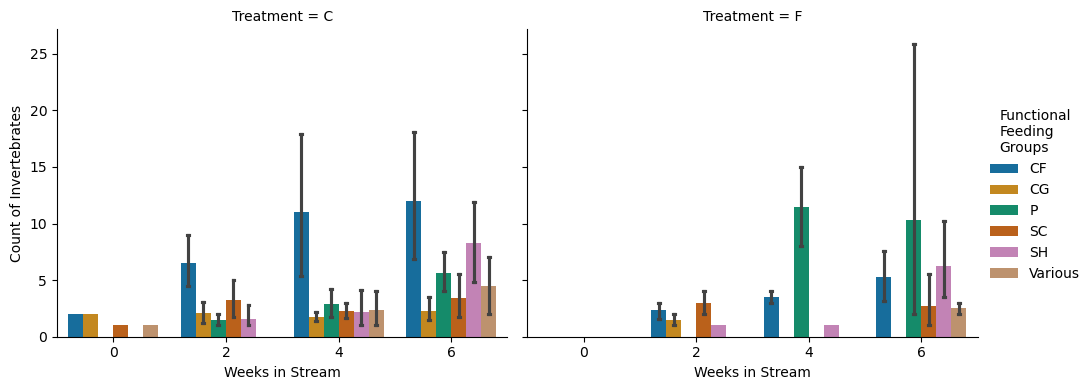

In [171]:
#Average Abundance of Invertebrates Through Days in Stream by FFG
#ffg_order = sorted(invert_unique_df['FFG'].unique())
week_order = sorted(invert_df['Week'].unique())
invert_order = ['CF','CG','P','SC','SH','Various']

g = sns.FacetGrid(data=invert_unique_df, col='Treatment', 
                  height=4, aspect=1.25 #, ylim=(0,40), xlim=(0,6)
                 )
g.map_dataframe(sns.barplot, 
                x='Week', y='Count', 
                hue='FFG', palette='colorblind', 
                order=week_order, hue_order=invert_order, capsize=0.1)

g.tight_layout()
g.set_axis_labels("Weeks in Stream", "Count of Invertebrates")
g.add_legend(title='Functional\nFeeding\nGroups')
#plt.suptitle("", y=1.02)

# Displaying the plots
plt.show()

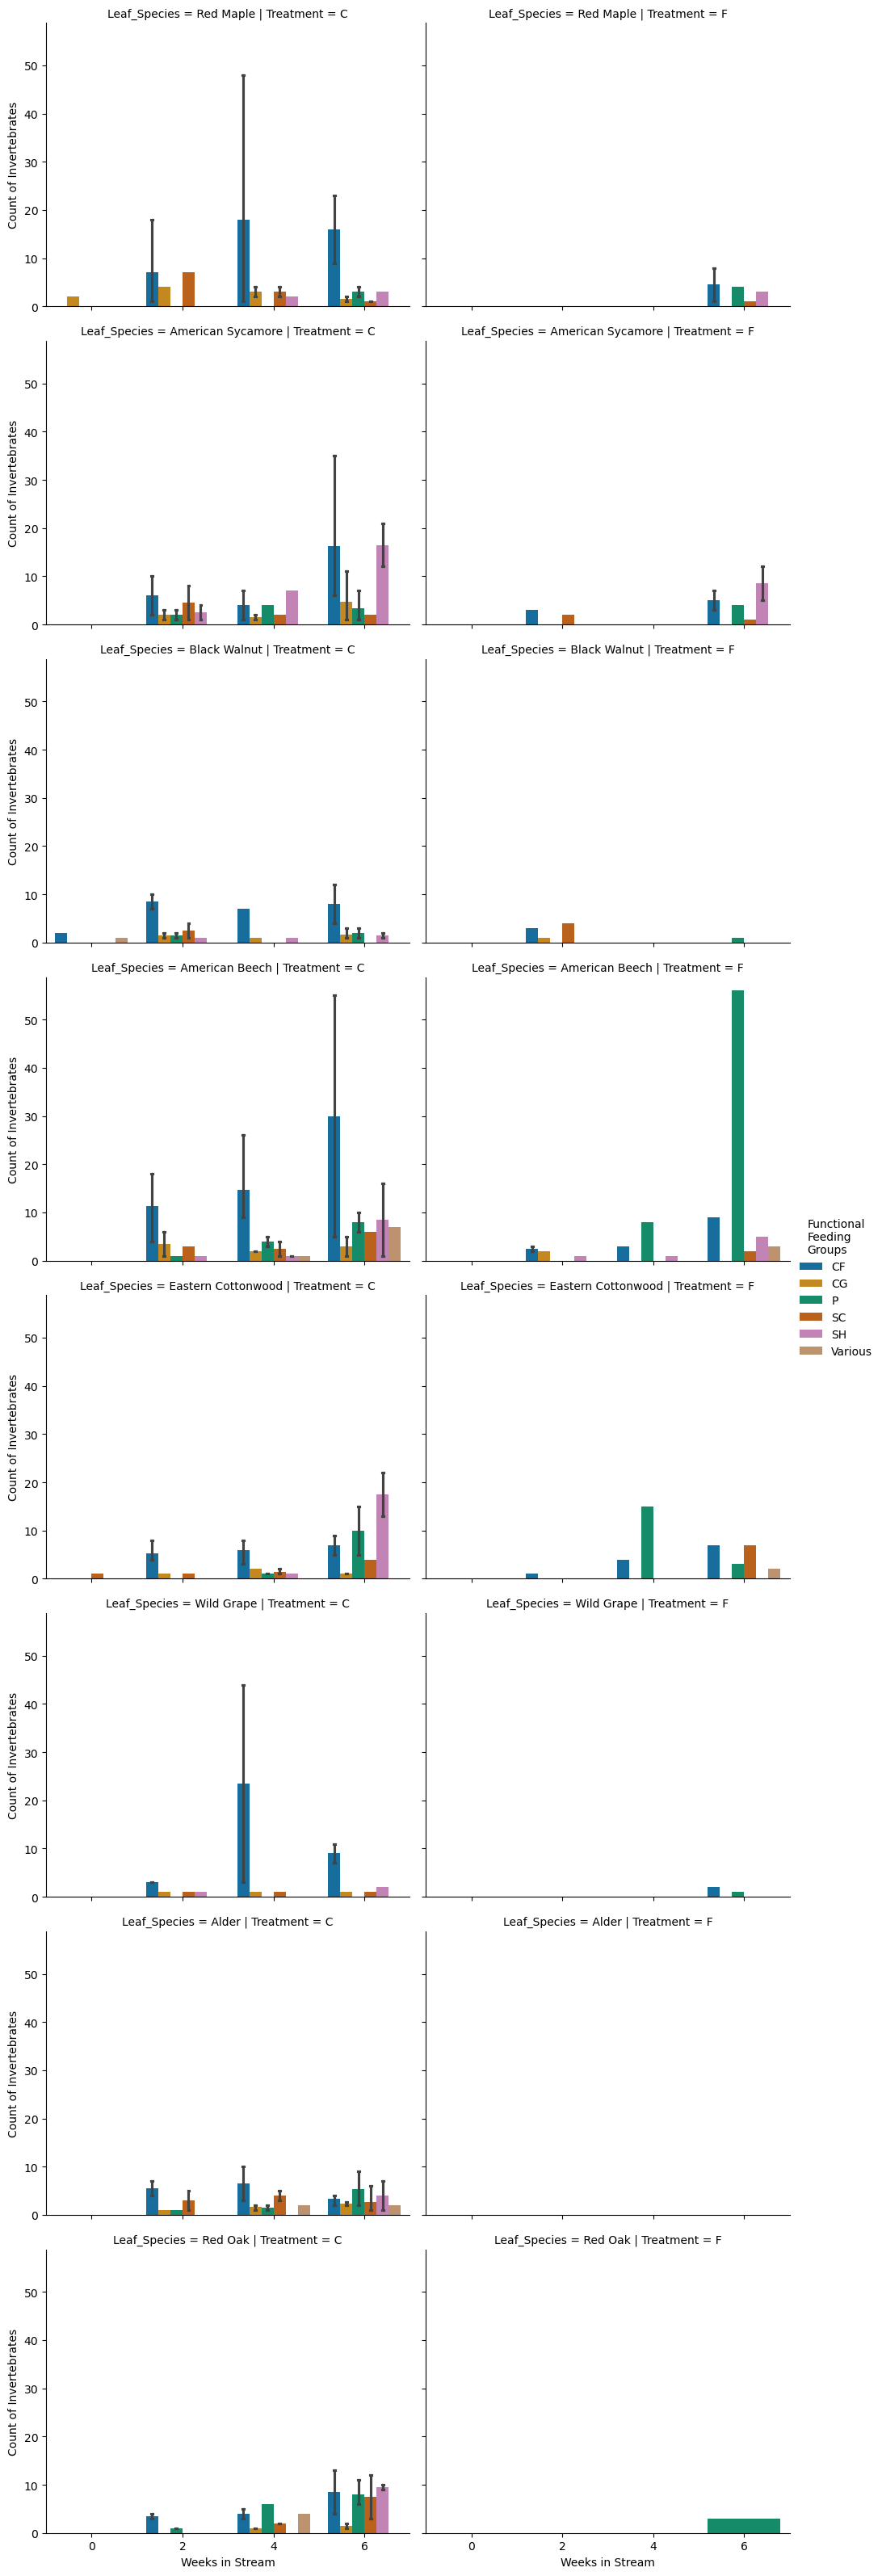

In [173]:
#Average Abundance of Invertebrates Through Days in Stream by FFG
#ffg_order = sorted(invert_unique_df['FFG'].unique())
week_order = sorted(invert_df['Week'].unique())
invert_order = ['CF','CG','P','SC','SH','Various']

g = sns.FacetGrid(data=invert_unique_df, col='Treatment', row='Leaf_Species',
                  height=4, aspect=1.25 #, ylim=(0,40), xlim=(0,6)
                 )
g.map_dataframe(sns.barplot, 
                x='Week', y='Count', 
                hue='FFG', palette='colorblind', 
                order=week_order, hue_order=invert_order, capsize=0.1)

g.tight_layout()
g.set_axis_labels("Weeks in Stream", "Count of Invertebrates")
g.add_legend(title='Functional\nFeeding\nGroups')
#plt.suptitle("", y=1.02)

# Displaying the plots
plt.show()

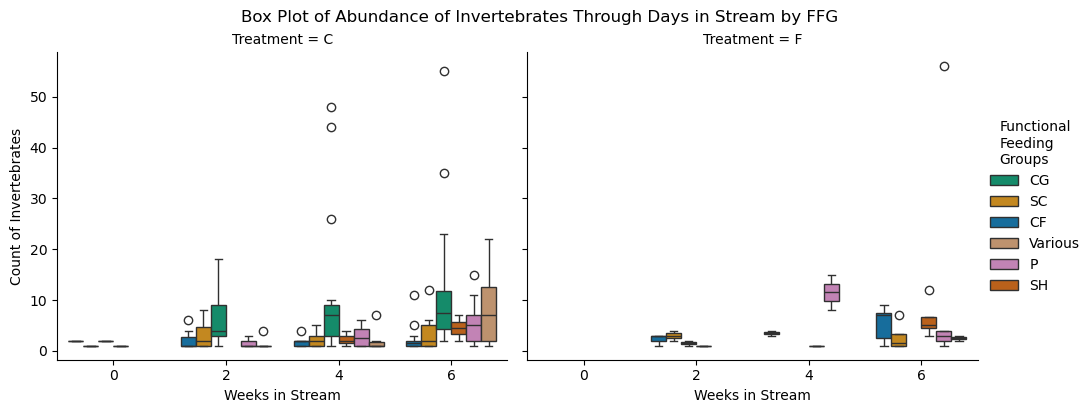

In [55]:
#ffg_order = sorted(invert_unique_df['FFG'].unique())
week_order = sorted(invert_df['Week'].unique())

g = sns.FacetGrid(data=invert_unique_df, col='Treatment', 
                  height=4, aspect=1.25 #, ylim=(0,40), xlim=(0,6)
                 )
g.map_dataframe(sns.boxplot, 
                x='Week', y='Count', 
                hue='FFG', palette='colorblind', 
                order=week_order)

g.tight_layout()
g.set_axis_labels("Weeks in Stream", "Count of Invertebrates")
g.add_legend(title='Functional\nFeeding\nGroups')
plt.suptitle("Box Plot of Abundance of Invertebrates Through Days in Stream by FFG", y=1.02)

# Displaying the plots
plt.show()

### ANOVA

#### Abundance Between Weeks, Treatment and Species

In [56]:
print(stats.shapiro(invert_sum_trans_df['Count']))
print(stats.shapiro(invert_sum_trans_df['sqrt_Count']))
print(stats.shapiro(invert_sum_trans_df['log_Count']))

ShapiroResult(statistic=0.7447356581687927, pvalue=1.7591549050788302e-10)
ShapiroResult(statistic=0.923245906829834, pvalue=0.00013579029473476112)
ShapiroResult(statistic=0.9768903255462646, pvalue=0.15603043138980865)


In [57]:
for var in ['Count', 'sqrt_Count', 'log_Count']:
    print(stats.levene(invert_sum_trans_df[var].loc[invert_sum_trans_df['Week']==0],
                       invert_sum_trans_df[var].loc[invert_sum_trans_df['Week']==2], 
                       invert_sum_trans_df[var].loc[invert_sum_trans_df['Week']==4],
                       invert_sum_trans_df[var].loc[invert_sum_trans_df['Week']==6]))

LeveneResult(statistic=2.9630181872231214, pvalue=0.037385862311904224)
LeveneResult(statistic=2.146800073659588, pvalue=0.10128678468537176)
LeveneResult(statistic=0.7333575083825601, pvalue=0.5353072085283825)


In [58]:
model = ols('Count ~ C(Week) + C(Treatment) + C(Leaf_Species) + C(Week):C(Treatment) + C(Week):C(Leaf_Species) + C(Treatment):C(Leaf_Species) + C(Week):C(Treatment):C(Leaf_Species)', data=invert_sum_df).fit() 
result = sm.stats.anova_lm(model, type=2) 
  
result

,df,sum_sq,mean_sq,F,PR(>F)
C(Week),3.0,3776.095035,1258.698345,5.693535,0.002415
C(Treatment),1.0,482.301459,482.301459,2.181619,0.147498
C(Leaf_Species),7.0,3324.381108,474.911587,2.148192,0.060245
C(Week):C(Treatment),3.0,174.607963,58.202654,0.263271,0.851433
C(Week):C(Leaf_Species),21.0,6024.009905,286.857615,1.297558,0.233984
C(Treatment):C(Leaf_Species),7.0,1554.921702,222.131672,1.004780,0.442378
C(Week):C(Treatment):C(Leaf_Species),21.0,2604.180121,124.008577,0.560934,0.921089
Residual,40.0,8843.000000,221.075000,NaN,NaN


In [59]:
model = ols('log_Count ~ C(Week) + C(Treatment) + C(Leaf_Species) + C(Week):C(Treatment) + C(Week):C(Leaf_Species) + C(Treatment):C(Leaf_Species) + C(Week):C(Treatment):C(Leaf_Species)', data=invert_sum_trans_df).fit() 
result = sm.stats.anova_lm(model, type=2) 
  
result

,df,sum_sq,mean_sq,F,PR(>F)
C(Week),3.0,16.615686,5.538562,7.808516,0.000322
C(Treatment),1.0,2.511808,2.511808,3.541260,0.067151
C(Leaf_Species),7.0,8.113726,1.159104,1.634157,0.153900
C(Week):C(Treatment),3.0,1.227973,0.409324,0.577084,0.633443
C(Week):C(Leaf_Species),21.0,11.788955,0.561379,0.791457,0.712541
C(Treatment):C(Leaf_Species),7.0,5.202108,0.743158,1.047738,0.414281
C(Week):C(Treatment):C(Leaf_Species),21.0,6.839184,0.325675,0.459152,0.970472
Residual,40.0,28.371906,0.709298,NaN,NaN


#### Richness Between Weeks, Treatment and Species

In [82]:
print(stats.shapiro(invert_genera_richness_trans_df['Genera_Richness']))
print(stats.shapiro(invert_genera_richness_trans_df['sqrt_Genera_Richness']))
print(stats.shapiro(invert_genera_richness_trans_df['log_Genera_Richness']))

ShapiroResult(statistic=0.9191818237304688, pvalue=8.700022590346634e-05)
ShapiroResult(statistic=0.945404052734375, pvalue=0.001898149843327701)
ShapiroResult(statistic=0.9377784132957458, pvalue=0.0007336376584134996)


In [83]:
for var in ['Genera_Richness', 'sqrt_Genera_Richness', 'log_Genera_Richness']:
    print(stats.levene(invert_genera_richness_trans_df[var].loc[invert_genera_richness_trans_df['Week']==0],
                       invert_genera_richness_trans_df[var].loc[invert_genera_richness_trans_df['Week']==2], 
                       invert_genera_richness_trans_df[var].loc[invert_genera_richness_trans_df['Week']==4],
                       invert_genera_richness_trans_df[var].loc[invert_genera_richness_trans_df['Week']==6]))

LeveneResult(statistic=2.031772497476897, pvalue=0.11651034242722104)
LeveneResult(statistic=1.3407356432326927, pvalue=0.26747372544640385)
LeveneResult(statistic=1.1443458221332912, pvalue=0.33671018859802215)


In [84]:
model = ols('Genera_Richness ~ C(Week) + C(Treatment) + C(Leaf_Species) + C(Week):C(Treatment) + C(Week):C(Leaf_Species)+ C(Treatment):C(Leaf_Species)+ C(Week):C(Treatment):C(Leaf_Species)', data=invert_genera_richness_df).fit() 
result = sm.stats.anova_lm(model, type=2) 
  
result

,df,sum_sq,mean_sq,F,PR(>F)
C(Week),3.0,112.458108,37.486036,5.591453,0.002675
C(Treatment),1.0,66.036211,66.036211,9.850025,0.003185
C(Leaf_Species),7.0,58.732437,8.390348,1.251512,0.298654
C(Week):C(Treatment),3.0,52.120144,17.373381,2.591430,0.066056
C(Week):C(Leaf_Species),21.0,121.188957,5.770903,0.860793,0.635724
C(Treatment):C(Leaf_Species),7.0,26.538030,3.791147,0.565491,0.779259
C(Week):C(Treatment):C(Leaf_Species),21.0,120.523738,5.739226,0.856068,0.640999
Residual,40.0,268.166667,6.704167,NaN,NaN


In [85]:
model = ols('sqrt_Genera_Richness ~ C(Week) + C(Treatment) + C(Leaf_Species) + C(Week):C(Treatment) + C(Week):C(Leaf_Species)+ C(Treatment):C(Leaf_Species)+ C(Week):C(Treatment):C(Leaf_Species)', data=invert_genera_richness_trans_df).fit() 
result = sm.stats.anova_lm(model, type=2) 
  
result

,df,sum_sq,mean_sq,F,PR(>F)
C(Week),3.0,6.931345,2.310448,5.708491,0.002379
C(Treatment),1.0,3.232725,3.232725,7.987187,0.007318
C(Leaf_Species),7.0,3.544043,0.506292,1.250910,0.298953
C(Week):C(Treatment),3.0,3.433907,1.144636,2.828085,0.050602
C(Week):C(Leaf_Species),21.0,6.786633,0.323173,0.798473,0.704871
C(Treatment):C(Leaf_Species),7.0,1.557958,0.222565,0.549899,0.791329
C(Week):C(Treatment):C(Leaf_Species),21.0,6.371673,0.303413,0.749651,0.757339
Residual,40.0,16.189554,0.404739,NaN,NaN


In [86]:
model = ols('log_Genera_Richness ~ C(Week) + C(Treatment) + C(Leaf_Species) + C(Week):C(Treatment) + C(Week):C(Leaf_Species)+ C(Treatment):C(Leaf_Species)+ C(Week):C(Treatment):C(Leaf_Species)', data=invert_genera_richness_trans_df).fit() 
result = sm.stats.anova_lm(model, type=2) 
  
result

,df,sum_sq,mean_sq,F,PR(>F)
C(Week),3.0,4.506300,1.502100,5.657995,0.002502
C(Treatment),1.0,1.807589,1.807589,6.808689,0.012699
C(Leaf_Species),7.0,2.271817,0.324545,1.222473,0.313351
C(Week):C(Treatment),3.0,2.308624,0.769541,2.898650,0.046753
C(Week):C(Leaf_Species),21.0,4.258925,0.202806,0.763914,0.742256
C(Treatment):C(Leaf_Species),7.0,1.037147,0.148164,0.558092,0.785004
C(Week):C(Treatment):C(Leaf_Species),21.0,3.938740,0.187559,0.706483,0.801312
Residual,40.0,10.619309,0.265483,NaN,NaN


#### Abundance between Weeks

In [87]:
invert_sum_df

,Group,Leaf_Species,Week,Treatment,Count
0,3,Red Maple,0,C,2.0
1,3,Red Maple,2,C,1.0
2,3,Red Maple,4,C,3.0
3,2,American Sycamore,4,C,3.0
4,2,American Sycamore,2,C,1.0
...,...,...,...,...,...
75,5,Eastern Cottonwood,6,C,32.0
76,5,Eastern Cottonwood,6,F,19.0
77,7,Wild Grape,2,C,4.0
78,9,Red Oak,6,F,3.0


In [88]:
invert_sum_trans_df = invert_sum_df.copy()
invert_sum_trans_df['sqrt_Count'] = np.sqrt(invert_sum_trans_df['Count'])
invert_sum_trans_df['log_Count'] = np.log(invert_sum_trans_df['Count']+1)

In [90]:
comp = mc.MultiComparison(invert_sum_trans_df['Count'], invert_sum_trans_df['Week'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,2,6.1852,0.9147,-18.7559,31.1263,False
0,4,13.6667,0.4914,-11.6282,38.9615,False
0,6,21.3448,0.1178,-3.5101,46.1998,False
2,4,7.4815,0.3583,-4.4426,19.4056,False
2,6,15.1596,0.0028,4.1996,26.1196,True
4,6,7.6782,0.3218,-4.0647,19.421,False


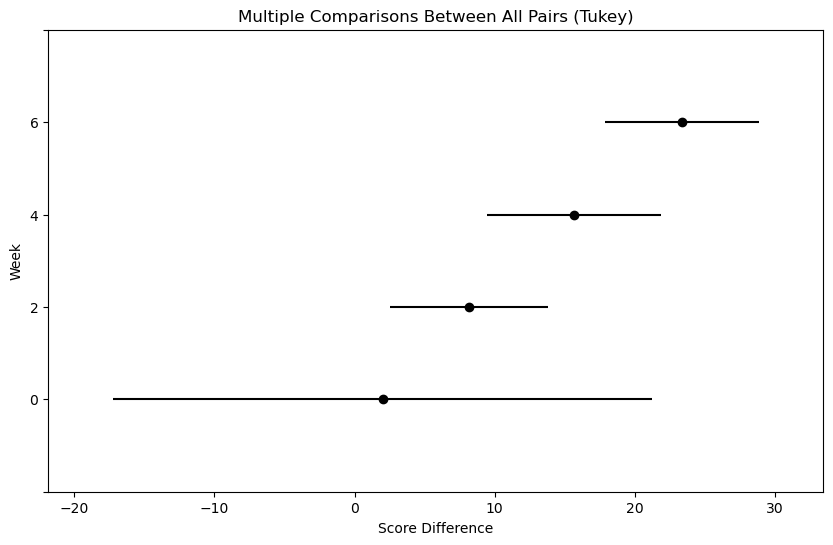

In [91]:
post_hoc_res.plot_simultaneous(ylabel= "Week", xlabel= "Score Difference");

In [127]:
comp = mc.MultiComparison(invert_sum_trans_df['log_Count'], invert_sum_trans_df['Week'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,2,0.8824,0.3073,-0.4448,2.2096,False
0,4,1.4391,0.0315,0.0931,2.7851,True
0,6,1.7718,0.004,0.4492,3.0945,True
2,4,0.5567,0.106,-0.0778,1.1912,False
2,6,0.8894,0.0008,0.3062,1.4727,True
4,6,0.3327,0.5041,-0.2921,0.9576,False


#### Richness between Weeks

In [93]:
invert_genera_richness_trans_df = invert_genera_richness_df.copy()
invert_genera_richness_trans_df['sqrt_Genera_Richness'] = np.sqrt(invert_genera_richness_trans_df['Genera_Richness'])
invert_genera_richness_trans_df['log_Genera_Richness'] = np.log(invert_genera_richness_trans_df['Genera_Richness']+1)

In [95]:
comp = mc.MultiComparison(invert_genera_richness_trans_df['Genera_Richness'], invert_genera_richness_trans_df['Week'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,2,2.0,0.5955,-2.1933,6.1933,False
0,4,3.0476,0.2442,-1.2052,7.3004,False
0,6,4.4253,0.0337,0.2464,8.6041,True
2,4,1.0476,0.5202,-0.9572,3.0524,False
2,6,2.4253,0.0049,0.5826,4.268,True
4,6,1.3777,0.2661,-0.5967,3.352,False


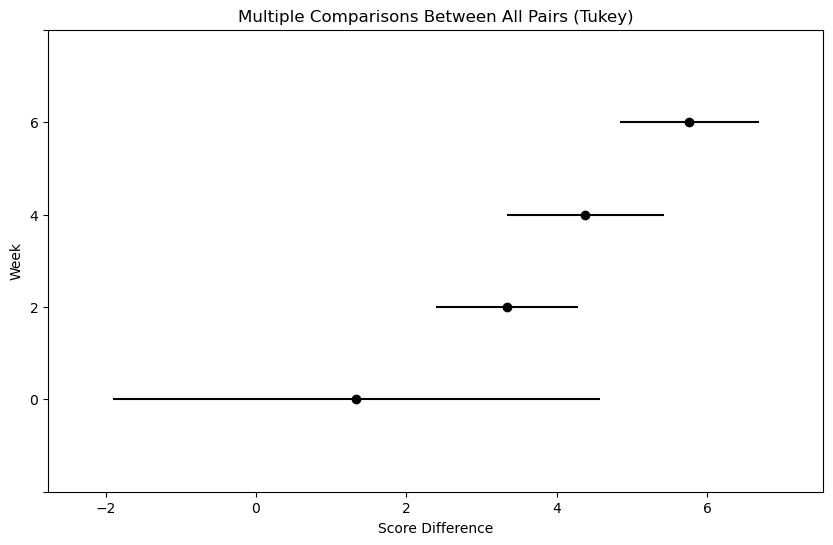

In [96]:
post_hoc_res.plot_simultaneous(ylabel= "Week", xlabel= "Score Difference");

In [107]:
comp = mc.MultiComparison(invert_genera_richness_trans_df['sqrt_Genera_Richness'], invert_genera_richness_trans_df['Week'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,2,0.5824,0.4305,-0.4238,1.5885,False
0,4,0.8832,0.1134,-0.1372,1.9036,False
0,6,1.1611,0.0167,0.1584,2.1638,True
2,4,0.3008,0.3612,-0.1802,0.7819,False
2,6,0.5787,0.0052,0.1366,1.0209,True
4,6,0.2779,0.4184,-0.1958,0.7516,False


#### Richness between Treatment:Week

In [97]:
response = invert_genera_richness_trans_df['sqrt_Genera_Richness']
group = invert_genera_richness_trans_df['Week'].astype(str) + "-" + invert_genera_richness_trans_df['Treatment']  

tukey_result = mc.pairwise_tukeyhsd(response, group)
tukey_result.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0-C,2-C,0.619,0.6314,-0.4983,1.7362,False
0-C,2-F,0.4212,0.9602,-0.9045,1.747,False
0-C,4-C,0.9303,0.1741,-0.1975,2.0581,False
0-C,4-F,0.4351,0.9847,-1.2221,2.0922,False
0-C,6-C,1.3886,0.0063,0.2647,2.5125,True
0-C,6-F,0.6555,0.6557,-0.5547,1.8658,False
2-C,2-F,-0.1977,0.994,-1.0971,0.7016,False
2-C,4-C,0.3114,0.6439,-0.2572,0.8799,False
2-C,4-F,-0.1839,0.9996,-1.5246,1.1568,False
2-C,6-C,0.7696,0.0016,0.2088,1.3305,True


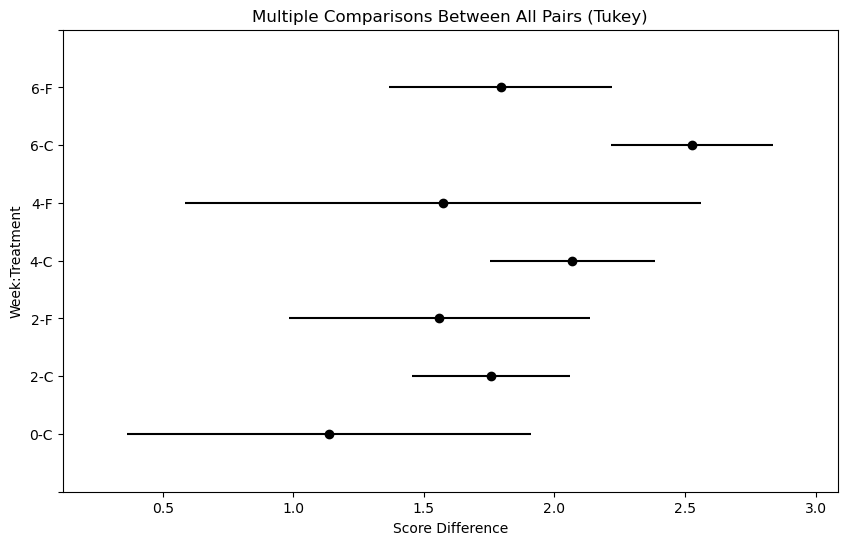

In [98]:
tukey_result.plot_simultaneous(ylabel= "Week:Treatment", xlabel= "Score Difference");

## Invertebrate and Mass Loss

### Data Manipulation

In [99]:
mass_df

,Group,Species,Replicate,Treatment,Week,Initial_Mass,Dried_Mass,Proportion,Corr_Factor,Corr_Proportion,ln_Corr_Proportion
0,1,Red Maple,1,C,0,3.00,2.80,0.933333,1.085538,1.013169,0.013083
1,1,Red Maple,2,C,0,3.00,2.70,0.900000,1.085538,0.976984,-0.023285
2,1,Red Maple,3,C,0,2.90,2.70,0.931034,1.085538,1.010673,0.010617
3,1,Red Maple,1,C,2,3.00,1.34,0.446667,1.085538,0.484874,-0.723867
4,1,Red Maple,2,C,2,3.00,1.10,0.366667,1.085538,0.398031,-0.921226
...,...,...,...,...,...,...,...,...,...,...,...
450,12,Red Oak,2,L,0,3.02,2.92,0.966887,1.000000,0.966887,-0.033673
451,12,Red Oak,3,L,0,2.97,3.04,1.023569,1.000000,1.023569,0.023296
452,12,Alder,1,L,0,3.00,2.42,0.806667,1.000000,0.806667,-0.214845
453,12,Alder,2,L,0,2.95,2.41,0.816949,1.000000,0.816949,-0.202178


In [100]:
invert_sum_df

,Group,Leaf_Species,Week,Treatment,Count
0,3,Red Maple,0,C,2.0
1,3,Red Maple,2,C,1.0
2,3,Red Maple,4,C,3.0
3,2,American Sycamore,4,C,3.0
4,2,American Sycamore,2,C,1.0
...,...,...,...,...,...
75,5,Eastern Cottonwood,6,C,32.0
76,5,Eastern Cottonwood,6,F,19.0
77,7,Wild Grape,2,C,4.0
78,9,Red Oak,6,F,3.0


In [101]:
mass_invert_abundance_df = mass_df.merge(invert_sum_df, 
                                         left_on=['Group','Species','Week','Treatment'], 
                                         right_on=['Group','Leaf_Species','Week','Treatment']).\
    rename({'Count':'Invert_Count'}, axis=1).drop(['Leaf_Species'], axis=1)
mass_invert_df = mass_invert_abundance_df.merge(invert_genera_richness_df, 
                                         left_on=['Group','Species','Week','Treatment'], 
                                         right_on=['Group','Leaf_Species','Week','Treatment']).drop(['Leaf_Species'], axis=1)

mass_invert_df

,Group,Species,Replicate,Treatment,Week,Initial_Mass,Dried_Mass,Proportion,Corr_Factor,Corr_Proportion,ln_Corr_Proportion,Invert_Count,Genera_Richness
0,1,Red Maple,1,C,2,3.00,1.34,0.446667,1.085538,0.484874,-0.723867,2.0,1
1,1,Red Maple,2,C,2,3.00,1.10,0.366667,1.085538,0.398031,-0.921226,2.0,1
2,1,Red Maple,3,C,2,3.00,1.33,0.443333,1.085538,0.481255,-0.731358,2.0,1
3,1,Red Maple,1,C,4,3.00,1.48,0.493333,1.085538,0.535532,-0.624495,7.0,2
4,1,Red Maple,2,C,4,3.00,1.47,0.490000,1.085538,0.531914,-0.631274,7.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,12,Alder,2,C,4,2.98,2.31,0.775168,1.055890,0.818492,-0.200292,2.0,1
211,12,Alder,3,C,4,3.00,1.73,0.576667,1.055890,0.608896,-0.496107,2.0,1
212,12,Alder,1,C,6,3.00,1.28,0.426667,1.055890,0.450513,-0.797369,18.0,7
213,12,Alder,2,C,6,3.00,1.21,0.403333,1.055890,0.425875,-0.853608,18.0,7


In [102]:
mass_invert_df[['ln_Corr_Proportion','Invert_Count','Genera_Richness']].corr()

,ln_Corr_Proportion,Invert_Count,Genera_Richness
ln_Corr_Proportion,1.000000,0.042144,0.154510
Invert_Count,0.042144,1.000000,0.652096
Genera_Richness,0.154510,0.652096,1.000000


### Visualisation

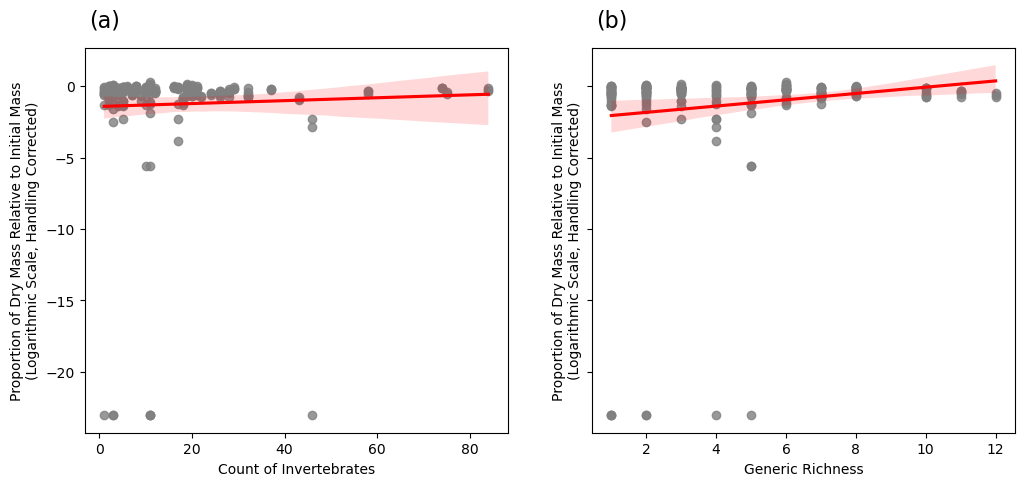

In [103]:
# Creating a figure with two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plotting the first graph on the top (ax1)
sns.regplot(data=mass_invert_df,x='Invert_Count', y='ln_Corr_Proportion', color='grey', line_kws=dict(color='r'), ax=ax1)

ax1.set(title='',xlabel='Count of Invertebrates',
        ylabel='Proportion of Dry Mass Relative to Initial Mass\n(Logarithmic Scale, Handling Corrected)')
ax1.text(0.01, 1.1, '(a)', transform=ax1.transAxes, fontsize=16, va='top')

# Plotting the second graph on the bottom (ax2)
sns.regplot(data=mass_invert_df,x='Genera_Richness', y='ln_Corr_Proportion', color='grey', line_kws=dict(color='r'), ax=ax2)

ax2.set(title='',
        xlabel='Generic Richness', ylabel='Proportion of Dry Mass Relative to Initial Mass\n(Logarithmic Scale, Handling Corrected)')
ax2.text(0.01, 1.1, '(b)', transform=ax2.transAxes, fontsize=16, va='top')


plt.show()

### t-Test

In [104]:
model = ols('ln_Corr_Proportion ~ Genera_Richness', data=mass_invert_df).fit() 
  
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     ln_Corr_Proportion   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     5.209
Date:                Wed, 06 Dec 2023   Prob (F-statistic):             0.0235
Time:                        01:26:02   Log-Likelihood:                -603.59
No. Observations:                 215   AIC:                             1211.
Df Residuals:                     213   BIC:                             1218.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -2.2817      0.523     -4.362      0.000      -3.313      -1.251
Genera_Richness     0.2202      0.096      2.282      0.023       0.030       0.410
==============================================================================
Omnibus:                      240.463   Durbin-Watson:                   1.355
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5479.848
Skew:                          -4.840   Prob(JB):                         0.00
Kurtosis:                      25.759   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
model = ols('ln_Corr_Proportion ~ Invert_Count', data=mass_invert_df).fit() 
  
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     ln_Corr_Proportion   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.3790
Date:                Wed, 06 Dec 2023   Prob (F-statistic):              0.539
Time:                        01:26:02   Log-Likelihood:                -606.00
No. Observations:                 215   AIC:                             1216.
Df Residuals:                     213   BIC:                             1223.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.4287      0.384     -3.724      0.000      -2.185      -0.672
Invert_Count     0.0102      0.017      0.616      0.539      -0.022       0.043
==============================================================================
Omnibus:                      246.504   Durbin-Watson:                   1.319
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6002.398
Skew:                          -5.009   Prob(JB):                         0.00
Kurtosis:                      26.868   Cond. No.                         32.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
import sys
print(sys.version)

3.11.4 (main, Jul  5 2023, 08:41:25) [Clang 14.0.6 ]
